In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import scipy.interpolate
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.stats import norm
import statsmodels.api as sm
from scipy.stats import uniform
from scipy.stats import norm
import numpy as np
import math
from time import time
import cvxpy as cp

In [2]:
def plot_g(df):
    seeds = df['Seed_num'].unique()   
    x = df[df['Seed_num'] == 1]['Maturity t']
    
    fig, ax = plt.subplots()

    max_seed = df.groupby('Seed_num').describe()['EstimatedPrice(t)']['mean'].idxmax()
    min_seed = df.groupby('Seed_num').describe()['EstimatedPrice(t)']['mean'].idxmin()
    mean_seed = df.groupby('Maturity t')['EstimatedPrice(t)'].mean().values
    std = df.groupby('Maturity t')['EstimatedPrice(t)'].std().values
    
    sns.lineplot(x = x, y = df[df['Seed_num'] == max_seed]['EstimatedPrice(t)'].values, label = 'max', color = 'darkviolet')
    sns.lineplot(x = x, y = df[df['Seed_num'] == min_seed]['EstimatedPrice(t)'].values, label = 'min', color = 'gold')
    sns.lineplot(x = x, y = mean_seed, label = 'mean', color = 'red')    
    sns.lineplot(x = x, y = mean_seed + std , label = '+std', color = 'navy')
    a = sns.lineplot(x = x, y = mean_seed - std , label = '-std', color = 'navy')

    line = a.get_lines()
    plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)
    
    plt.xlabel('date')
    plt.ylabel('Value')
    fig.set_figheight(6)
    fig.set_figwidth(10.5)
    plt.title('Martingale test for {} using {} seeds'.format(df.name, len(seeds)))
    plt.xticks(np.arange(0, x.max()+1, 10))
    plt.grid()
    plt.show() 

In [3]:
def martingale_test(df, asset):
    name = asset.split('.')[-2] if len(asset.split('.')) > 2 else asset
    df['Martingale'] = df[asset] / df['ESG.Economies.USD.NominalYieldCurves.NominalYieldCurve.CashTotalReturnIndex']
    df1 = df[['Seed_num', 'Martingale', 'Trial', 'Timestep']].groupby(['Timestep', 'Seed_num']).mean().reset_index()[['Timestep', 'Seed_num', 'Martingale']].copy()
    df1.rename(columns={'Timestep': 'Maturity t', 'Seed_num': 'Seed_num', 'Martingale': 'EstimatedPrice(t)'}, inplace=True)
    df1.sort_values(by = ['Seed_num', 'Maturity t'], inplace = True)
    df1.name = name
    
    return df1

In [4]:
def table(martingale_df):
    i = martingale_df

    max_seed = i.groupby('Seed_num').describe()['EstimatedPrice(t)']['mean'].idxmax()
    min_seed = i.groupby('Seed_num').describe()['EstimatedPrice(t)']['mean'].idxmin()
    max_test = i[i['Seed_num'] == max_seed]['EstimatedPrice(t)'].values
    min_test = i[i['Seed_num'] == min_seed]['EstimatedPrice(t)'].values
    std = i.groupby('Maturity t')['EstimatedPrice(t)'].std().values
    up_std = i.groupby('Maturity t')['EstimatedPrice(t)'].mean().values + std
    down_std = i.groupby('Maturity t')['EstimatedPrice(t)'].mean().values - std
 
    print('Asset: {}, Max above: {:.3f}, Min below: {:.3f}, |Average beyond|: {:.3f}, max std: {:.3f}'.format(i.name, np.sum(max_test > up_std) / len(up_std), np.sum(min_test < down_std) / len(down_std), max(np.mean(max_test - up_std), np.abs(np.mean(min_test - down_std))), max(std)))
    #l = [i.name, np.sum(max_test > up_std) / len(up_std), np.sum(min_test < down_std) / len(down_std), max(std), max(np.mean(max_test - up_std), np.abs(np.mean(min_test - down_std)))]
    #return l

In [41]:
df = pd.read_csv('Trajectories_noAnti_noMM.csv')

In [42]:
df.head()

Seed_num  Trial  Timestep  \
0         1      1         0   
1         1      1         1   
2         1      1         2   
3         1      1         3   
4         1      1         4   

   ESG.Economies.USD.NominalYieldCurves.NominalYieldCurve.CashTotalReturnIndex  \
0                                           1.000000                             
1                                           1.047671                             
2                                           1.062221                             
3                                           1.074251                             
4                                           1.086857                             

   ESG.Assets.EquityAssets.E_USD.TotalReturnIndex  \
0                                        1.000000   
1                                        1.209095   
2                                        1.246881   
3                                        1.385263   
4                                        1.642985   

   ESG.Assets.EquityAssets.E_JPY.TotalReturnIndex  \
0                                        1.000000   
1                                        1.117940   
2                                        1.128828   
3                                        1.446187   
4                                        2.220812   

   ESG.Assets.FixedIncome.GenericBondPortfolios.RiskyGenericBondPortfolio1.TotalReturnIndex  \
0                                           1.000000                                          
1                                           1.297941                                          
2                                           1.144363                                          
3                                           1.197699                                          
4                                           1.459052                                          

   ESG.Assets.EquityAssets.1.TotalReturnIndex  \
0                                    1.000000   
1                                    1.077810   
2                                    0.471763   
3                                    0.452606   
4                                    0.658516   

   ESG.Assets.EquityAssets.2.TotalReturnIndex  \
0                                    1.000000   
1                                    0.481128   
2                                    0.141017   
3                                    0.261118   
4                                    0.282110   

   ESG.Assets.EquityAssets.3.TotalReturnIndex  \
0                                    1.000000   
1                                    1.430417   
2                                    1.260526   
3                                    1.091493   
4                                    1.453111   

   ESG.Assets.EquityAssets.4.TotalReturnIndex  \
0                                    1.000000   
1                                    1.073149   
2                                    1.114513   
3                                    1.154546   
4                                    1.196502   

   ESG.Assets.EquityAssets.5.TotalReturnIndex  \
0                                    1.000000   
1                                    1.071643   
2                                    1.111387   
3                                    1.149692   
4                                    1.189799   

   ESG.Assets.EquityAssets.6.TotalReturnIndex  \
0                                    1.000000   
1                                    1.168850   
2                                    1.154999   
3                                    0.993902   
4                                    1.030702   

   ESG.Assets.EquityAssets.7.TotalReturnIndex  \
0                                    1.000000   
1                                    1.219529   
2                                    1.788401   
3                                    1.598018   
4                                    1.317001   

   ESG.Assets.EquityAssets.8.TotalReturnInd

In [7]:
df1 = df[['ESG.Assets.EquityAssets.7.TotalReturnIndex', 'Seed_num', 'Trial', 'Timestep']]

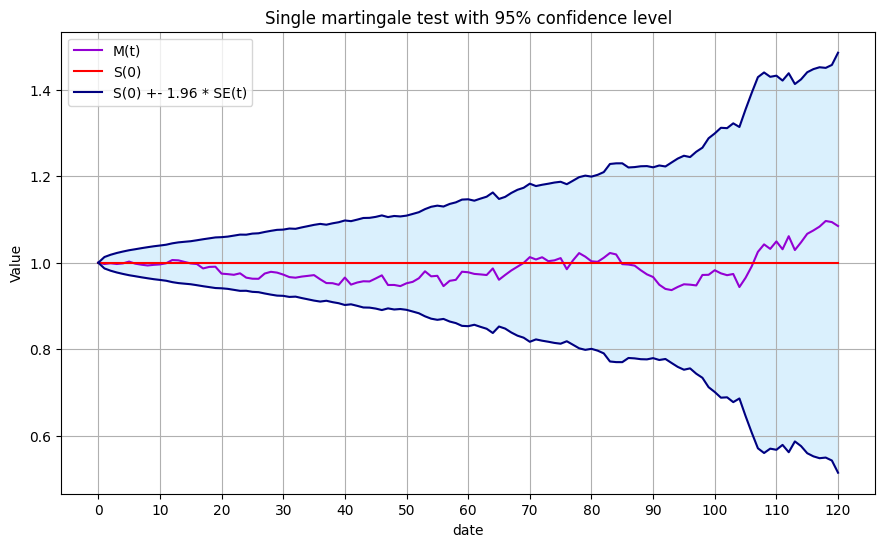

In [43]:
x = df1[df1['Seed_num'] == 7]['Maturity t']

fig, ax = plt.subplots()

sns.lineplot(x = x, y = df1[df1['Seed_num'] == 7]['EstimatedPrice(t)'].values, label = 'M(t)', color = 'darkviolet')
sns.lineplot(x = x, y = 1.0, label = 'S(0)', color = 'red')    
sns.lineplot(x = x, y = 1.0 + df1[df1['Seed_num'] == 7]['SE'].values * 1.96, label = 'S(0) +- 1.96 * SE(t)', color = 'navy')
a = sns.lineplot(x = x, y = 1.0 - df1[df1['Seed_num'] == 7]['SE'].values * 1.96, color = 'navy')

line = a.get_lines()
plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)

plt.xlabel('date')
plt.ylabel('Value')
fig.set_figheight(6)
fig.set_figwidth(10.5)
plt.title('Single martingale test with 95% confidence level')
#plt.title('Martingale test for {} using {} seeds'.format(df.name, len(seeds)))
plt.xticks(np.arange(0, x.max()+1, 10))
plt.grid()
plt.savefig('SampleMartingaleTest.png')
plt.show()

In [8]:
df_usd = martingale_test(df, 'ESG.Assets.FixedIncome.GenericBondPortfolios.RiskyGenericBondPortfolio1.TotalReturnIndex')

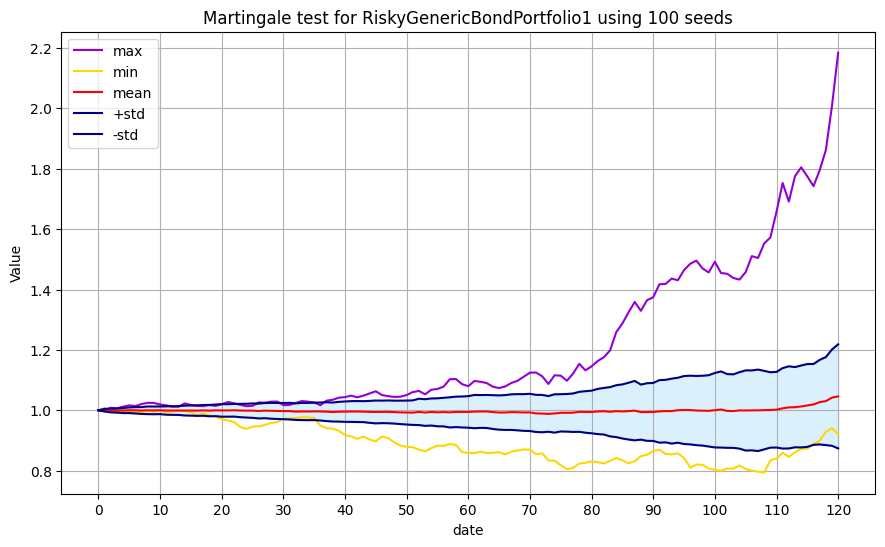

In [8]:
plot_g(df_usd)

In [5]:
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random
from matplotlib.widgets import Slider

In [7]:
old_n = ['E_USD', 'E_JPY'] + [str(i) for i in range(1, 11, 1)] + ['RiskyGenericBondPortfolio1']
new_n = ['USD', 'JPY', 'MR1', 'MR2', 'MR3', 'Jumps1', 'Jumps2', 'Jumps3', 'BS', 'Max', 'Average', 'Min', 'Bond']
names_d = {k:v for k, v in zip(old_n, new_n)}

### Moments Visualisation

In [14]:
def plot_moments(name):
    m1, m2 = 2, 3
    fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(14, 8))
    m = 5
    name_array = ['_False_None', '_True_None', '_False_Mean', '_False_MeanAndVariance', '_False_MeanVarianceAndAutoCorrelations']

    axes = ax.flatten()

    for i in range(m):
        temp = pd.read_csv('Moments_new/Moments' + name + name_array[i] + '.csv') 
        temp.insert(1, 'Timestep', np.tile(np.arange(0, 121, 1), 100))
        d1 = temp.groupby('Timestep').std()[1:]
        res = d1.reset_index().melt(id_vars='Timestep', var_name='Variable', value_name='mean')
        
            
        for idx in range(6):
            col = res['Variable'].unique()[1 + idx]

            sns.lineplot(x = 'Timestep', y = 'mean', data = res[res['Variable'] == col], ax = axes[idx], label = i+1)# label = name_array[i][1:])
            
            axes[idx].set_title(col + ', ' + names_d[name])
            axes[idx].set_xlabel('Timestep')
            axes[idx].set_ylabel('Value')
            axes[idx].legend()
            axes[idx].set_yscale('log')
            axes[idx].set_xticks(np.arange(0, 121, 20))
            axes[idx].grid()
    
    plt.tight_layout()
    plt.savefig(name + 'moments.png')
    plt.show()

In [96]:
def mean_moments(name):
    q = ['Mean', 'StDev', 'Min', 'Max', 'Skew', 'Kurt']
    m = len(q)

    name_array = ['_False_None', '_True_None', '_False_Mean', '_False_MeanAndVariance', '_False_MeanVarianceAndAutoCorrelations']
    d = []
    for i in name_array:
        temp = pd.read_csv('Moments_new/Moments' + name + i + '.csv')
        temp.insert(1, 'Timestep', np.tile(np.arange(0, 121, 1), 100))
        d.append(temp)

    res = []

    for i in range(m):

        d_seed = {}
        for j in range(len(name_array)):
            t = d[j].groupby('Timestep').mean()[q[i]].values
            d_seed[name_array[j]] = np.nanmedian(t)

        temp = sorted(d_seed.items(), key = lambda x: x[1], reverse = True)
        max_index, min_index = temp[0][0], temp[-1][0]
        print('max:', q[i], max_index )
        print('min:', q[i], min_index )
        a1 = d[name_array.index(max_index)].groupby('Timestep').mean()[q[i]].values
        a2 = d[name_array.index(min_index)].groupby('Timestep').mean()[q[i]].values
        
        a1 = a1[~np.isnan(a1)]
        a2 = a2[~np.isnan(a2)]
        if (np.argwhere(a1 == 0) == np.argwhere(a2 == 0)).all() == True: 
            a1, a2 = a1[a1 != 0], a2[a2 != 0] 
        else: 
            assert False, 'zeros are not in the same positions'
        
        
        res.append(np.mean(np.abs(a2 - a1) / np.maximum(np.abs(a1) , np.abs(a2)) ))#( max() np.abs(a1 + a2))))
        
    #return a1, a2   
    return pd.DataFrame([res], columns=['Mean', 'StDev', 'Min', 'Max', 'Skew', 'Kurt'], index=[names_d[name]])

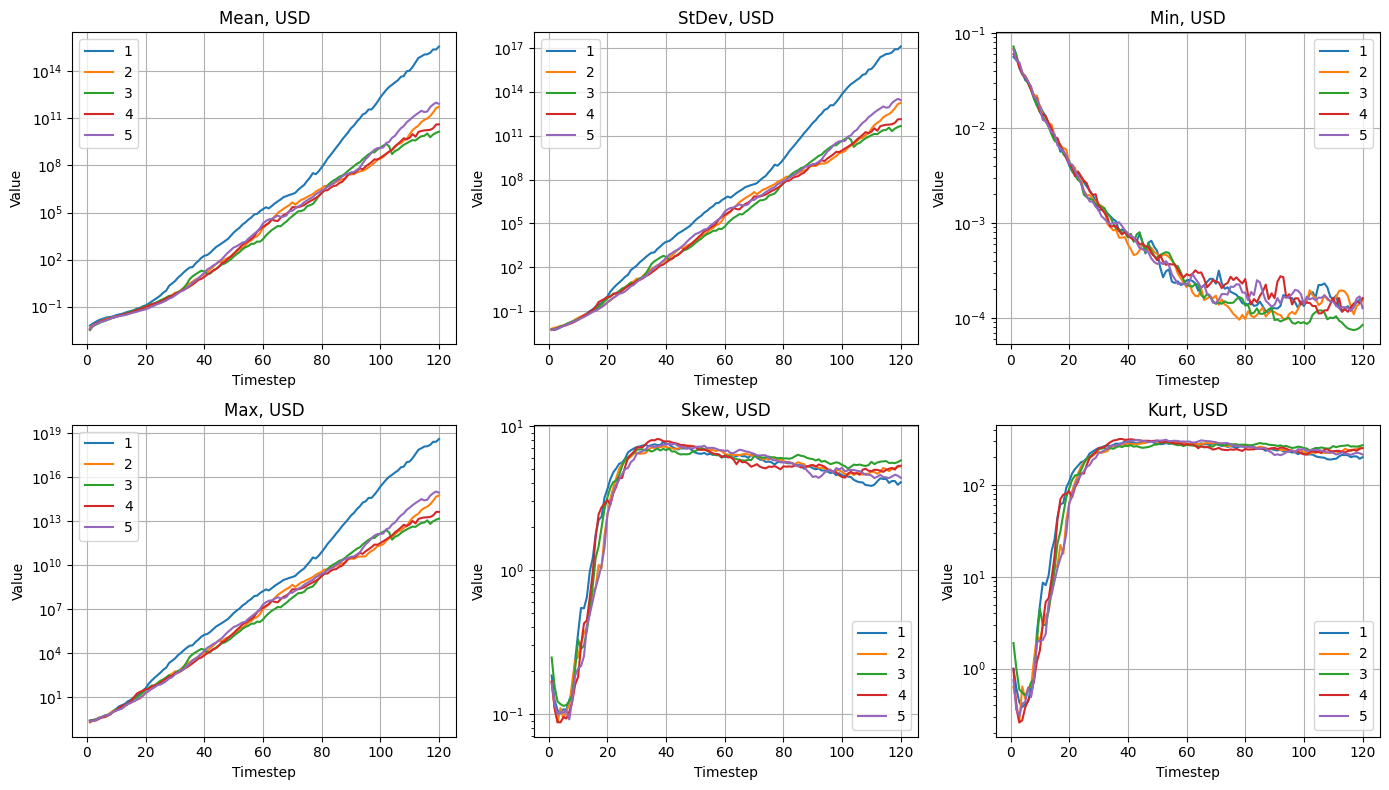

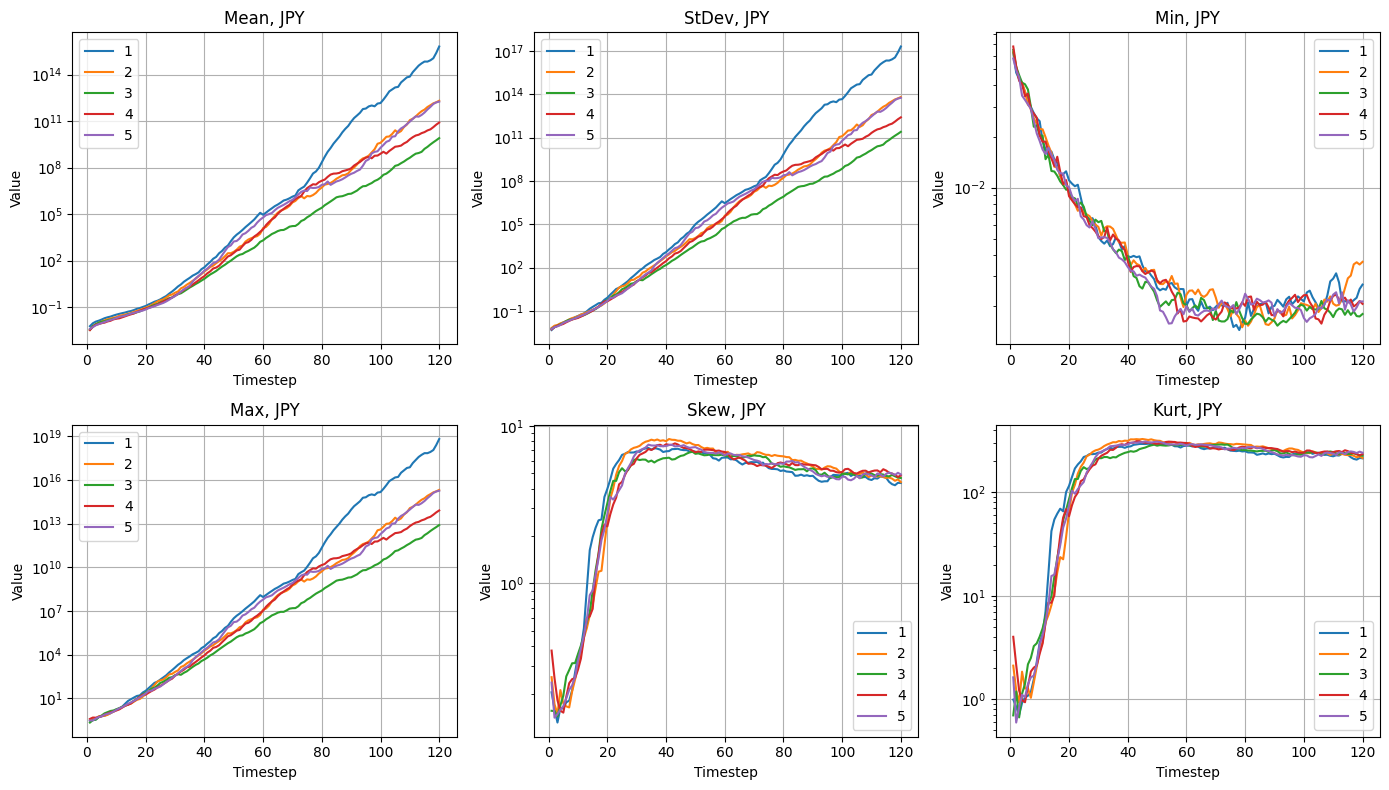

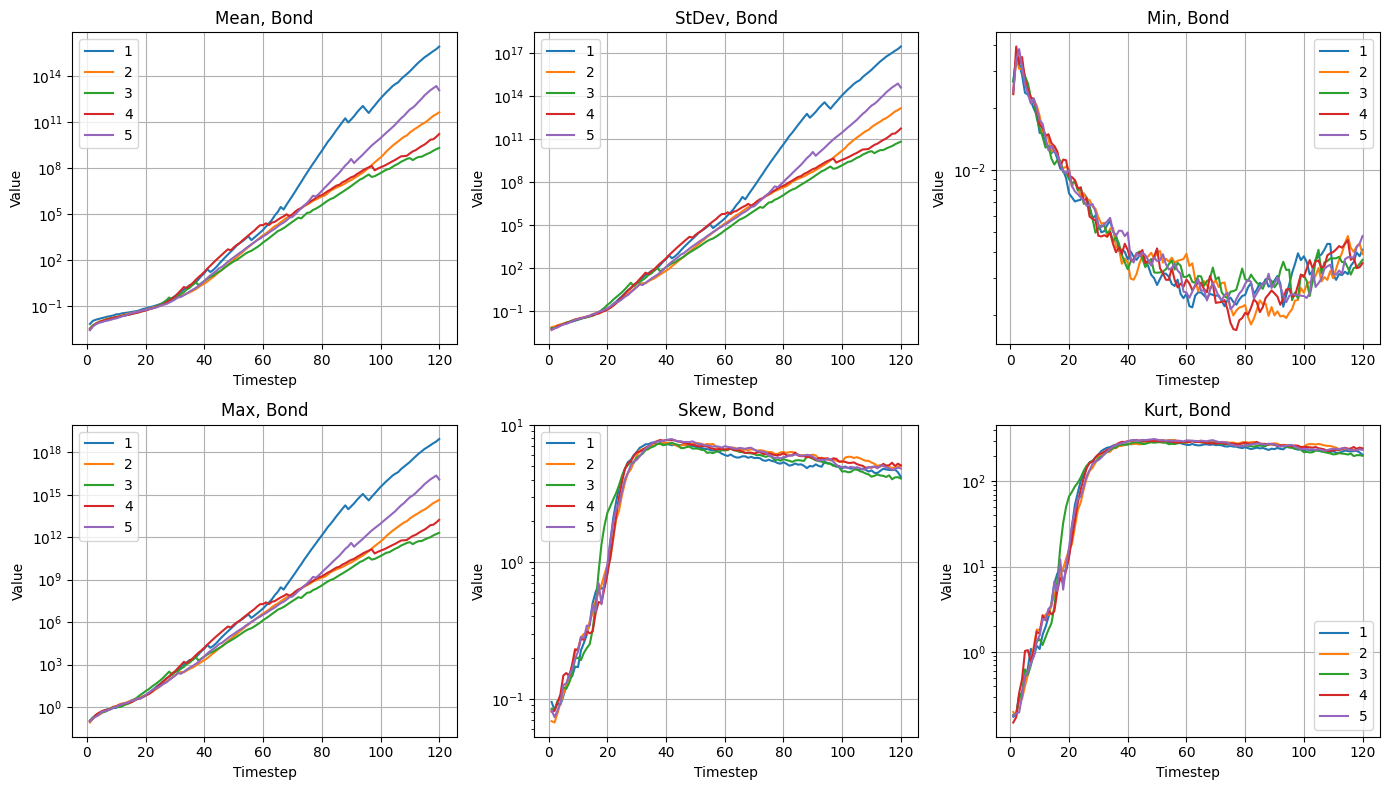

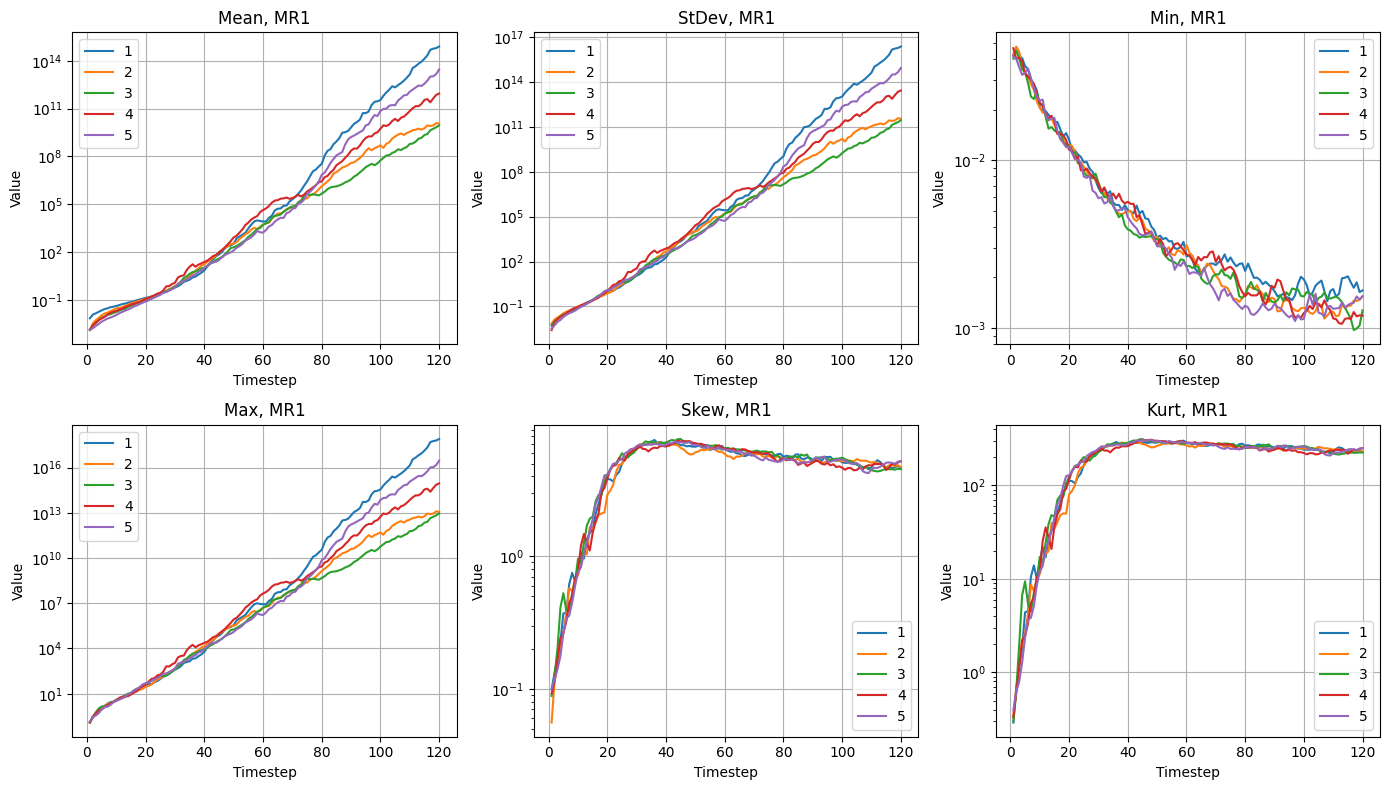

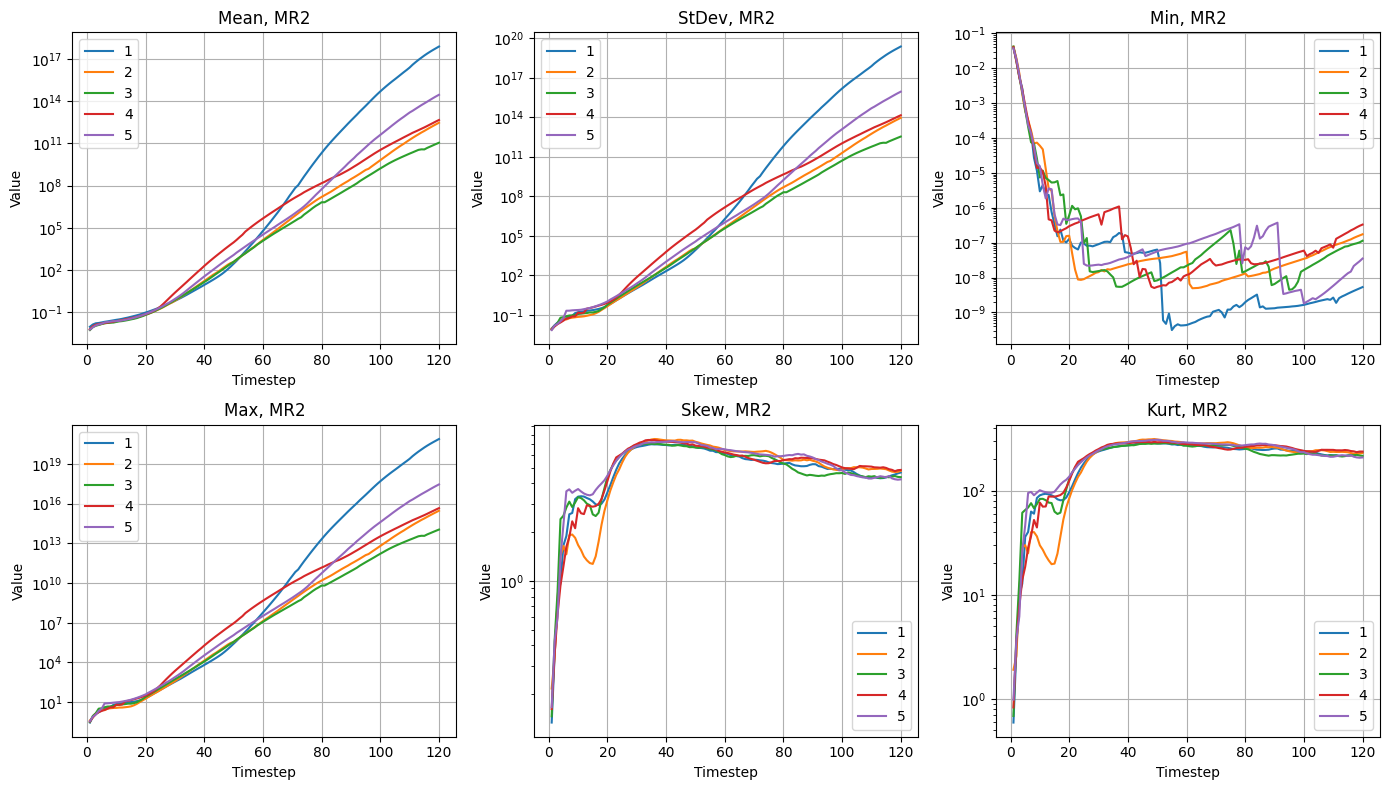

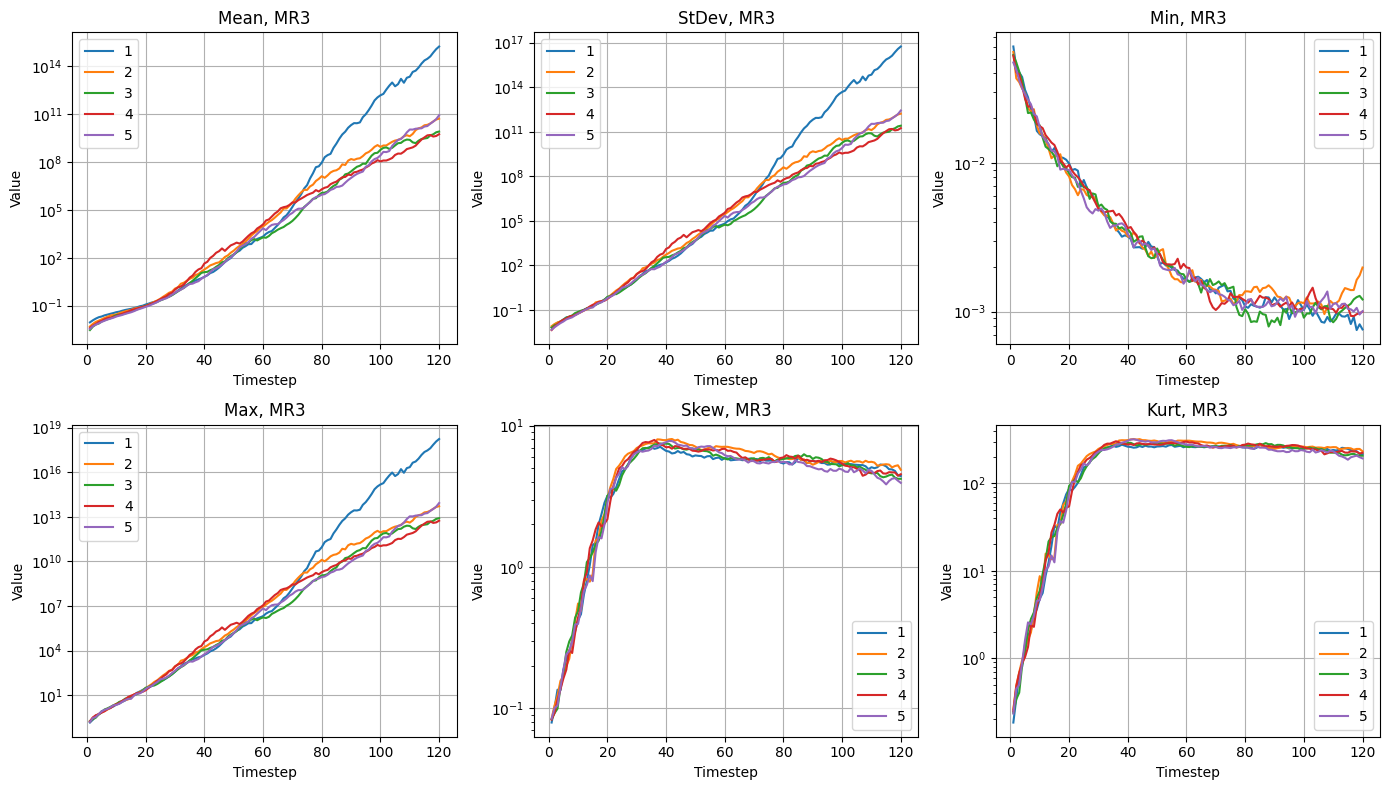

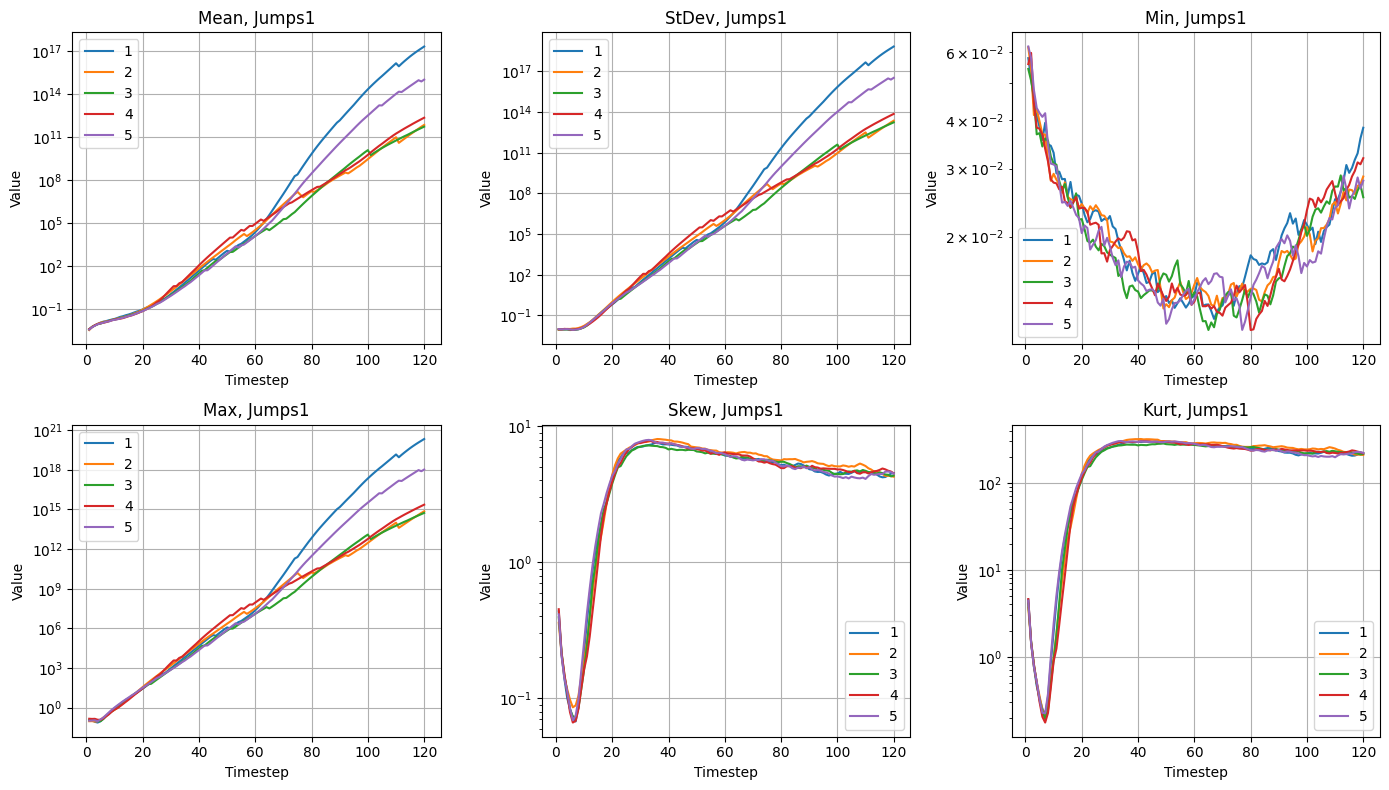

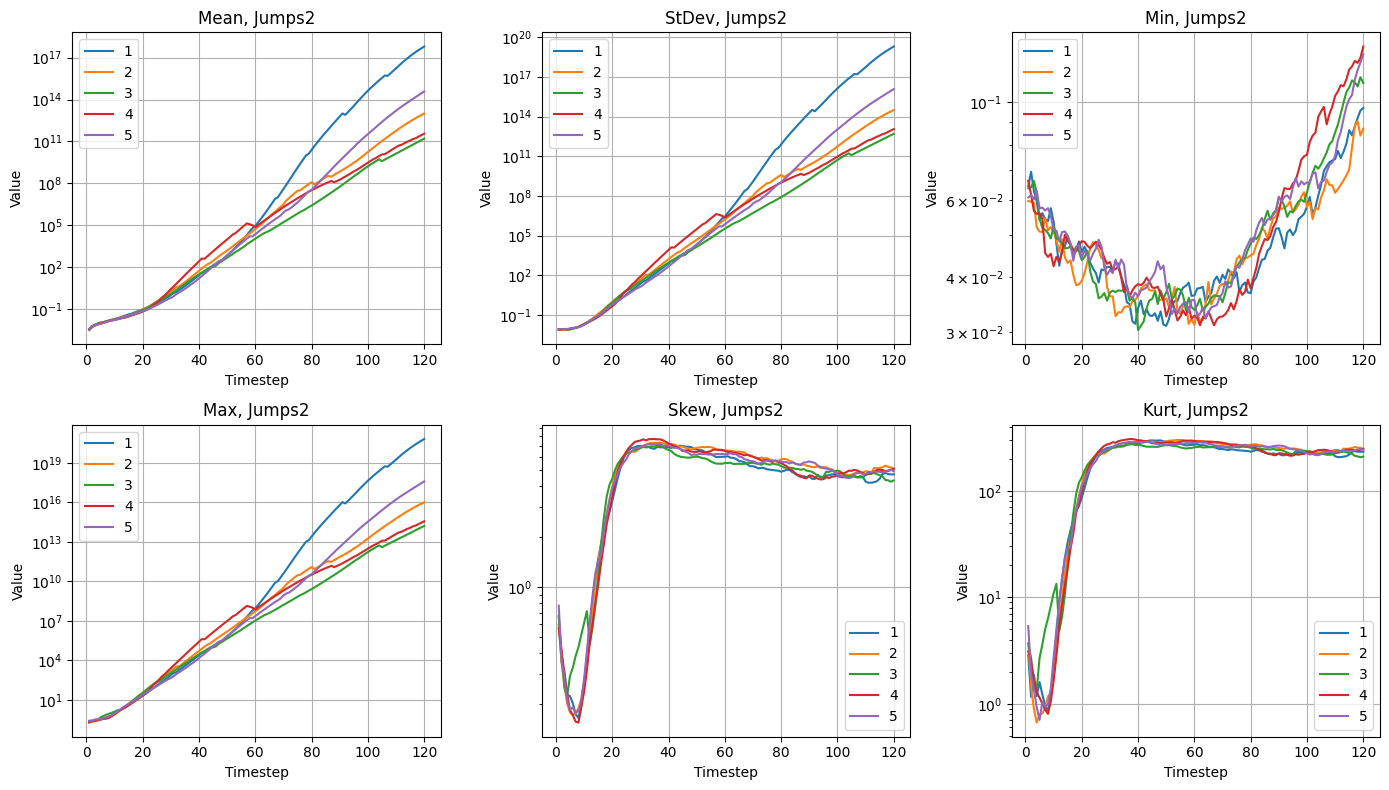

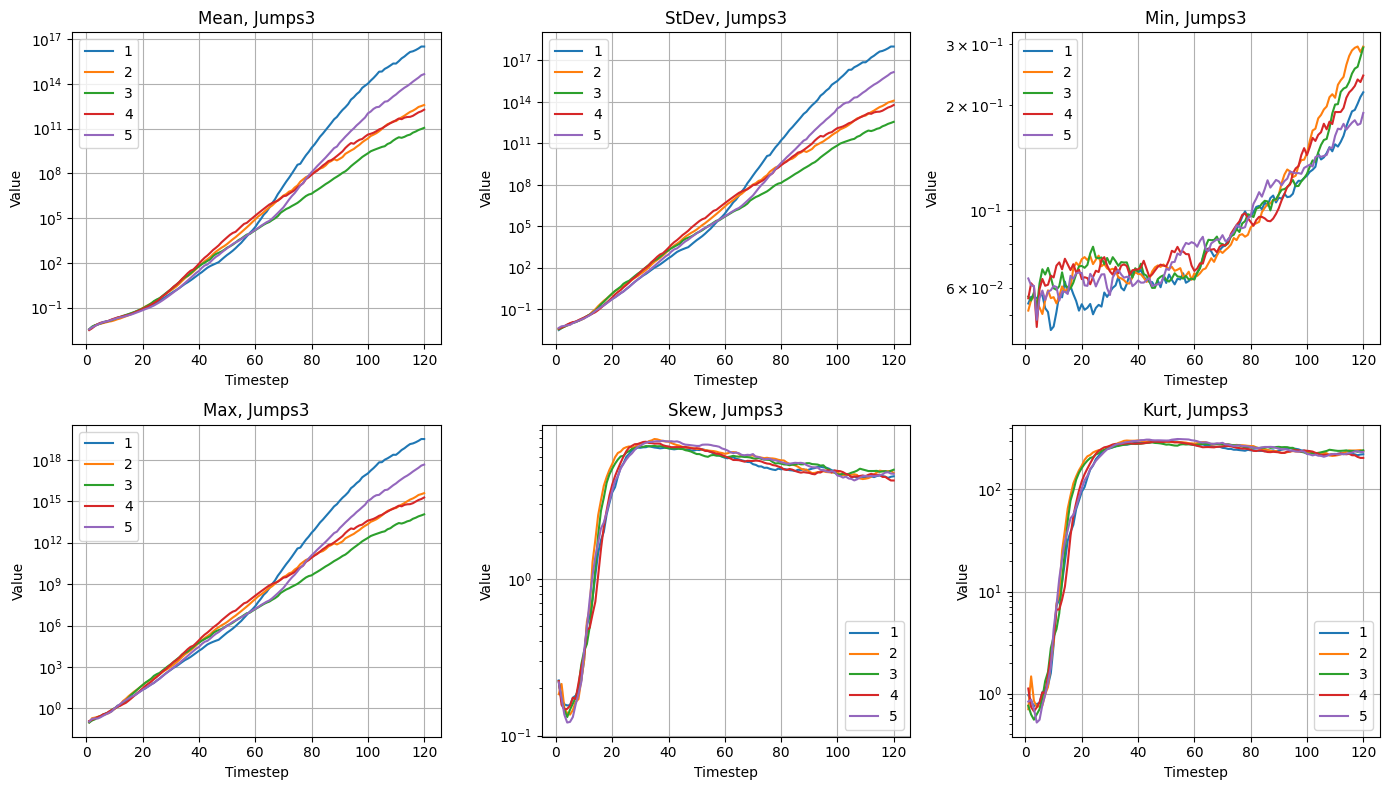

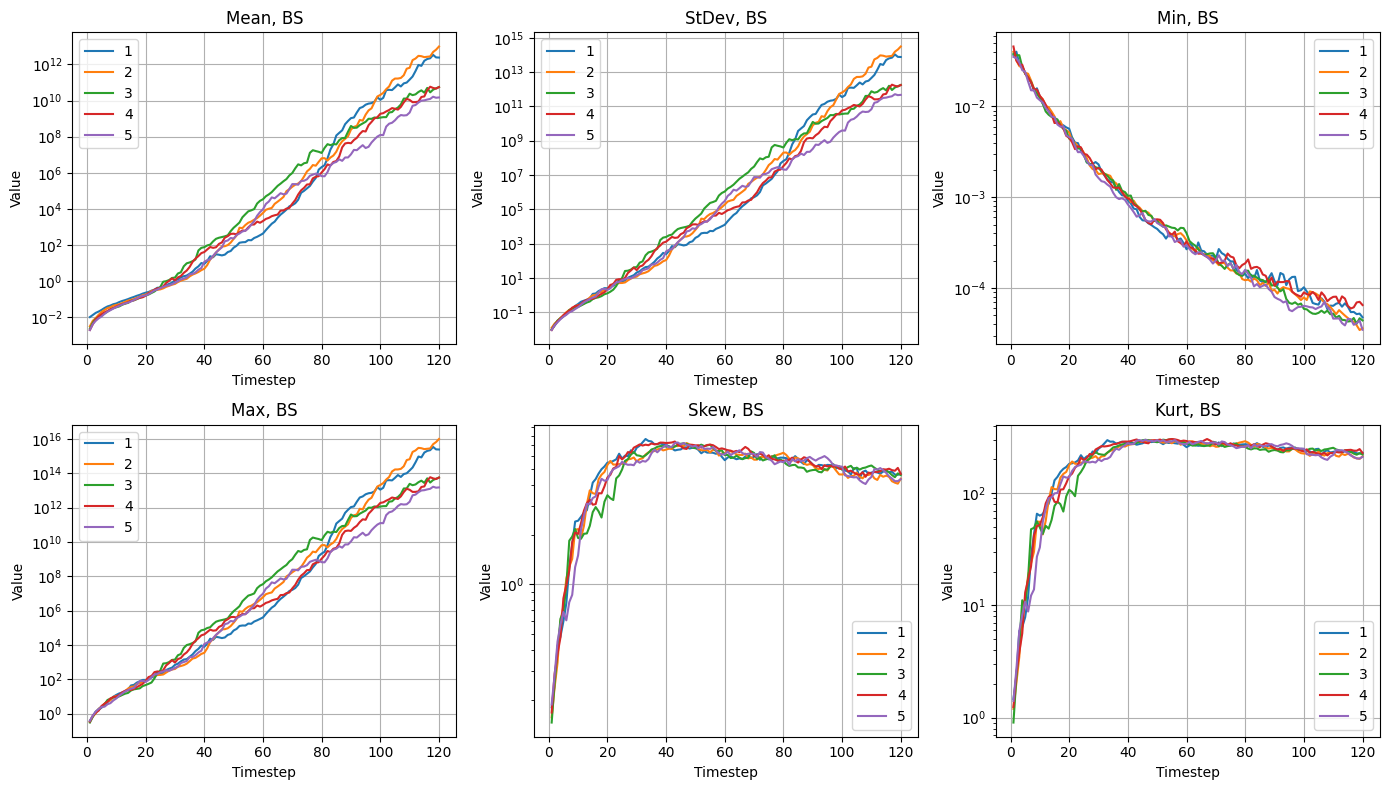

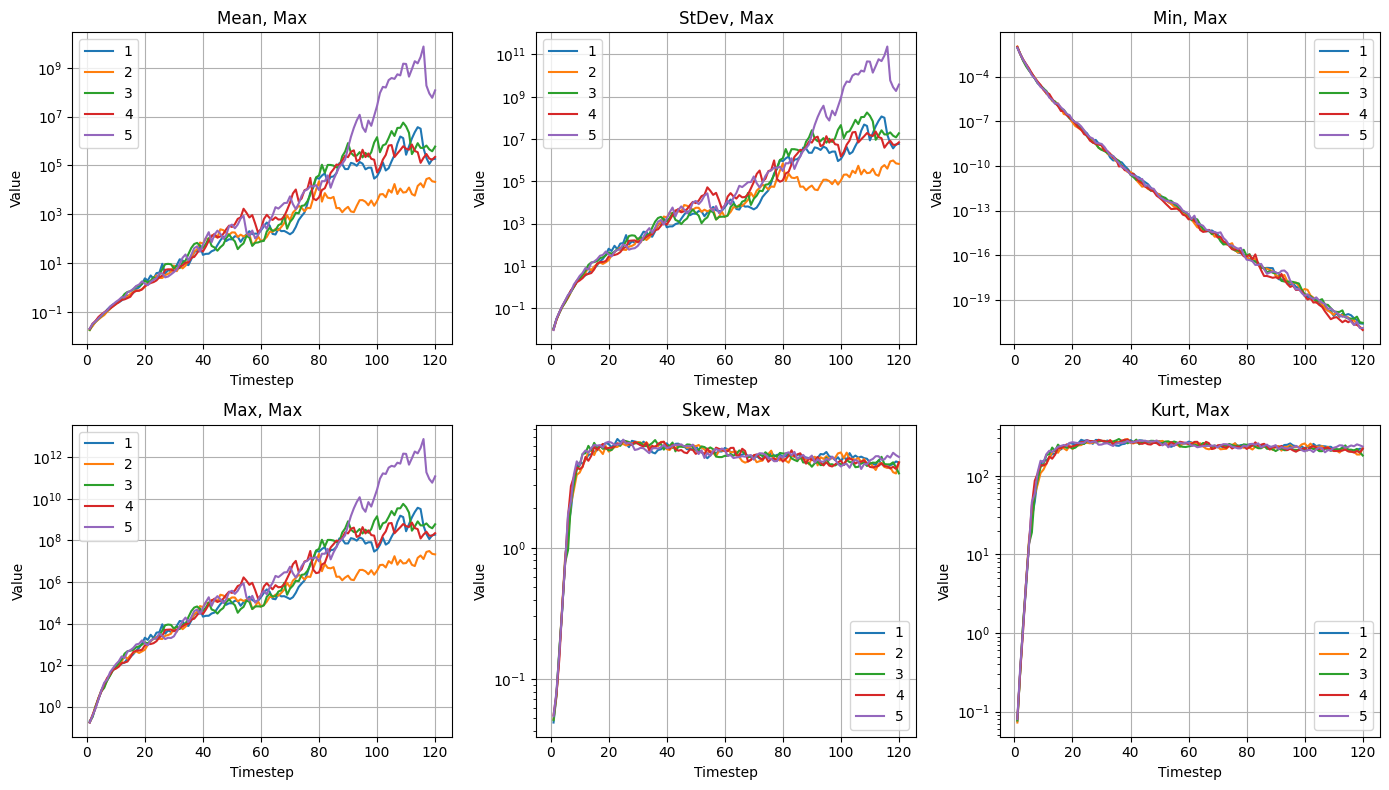

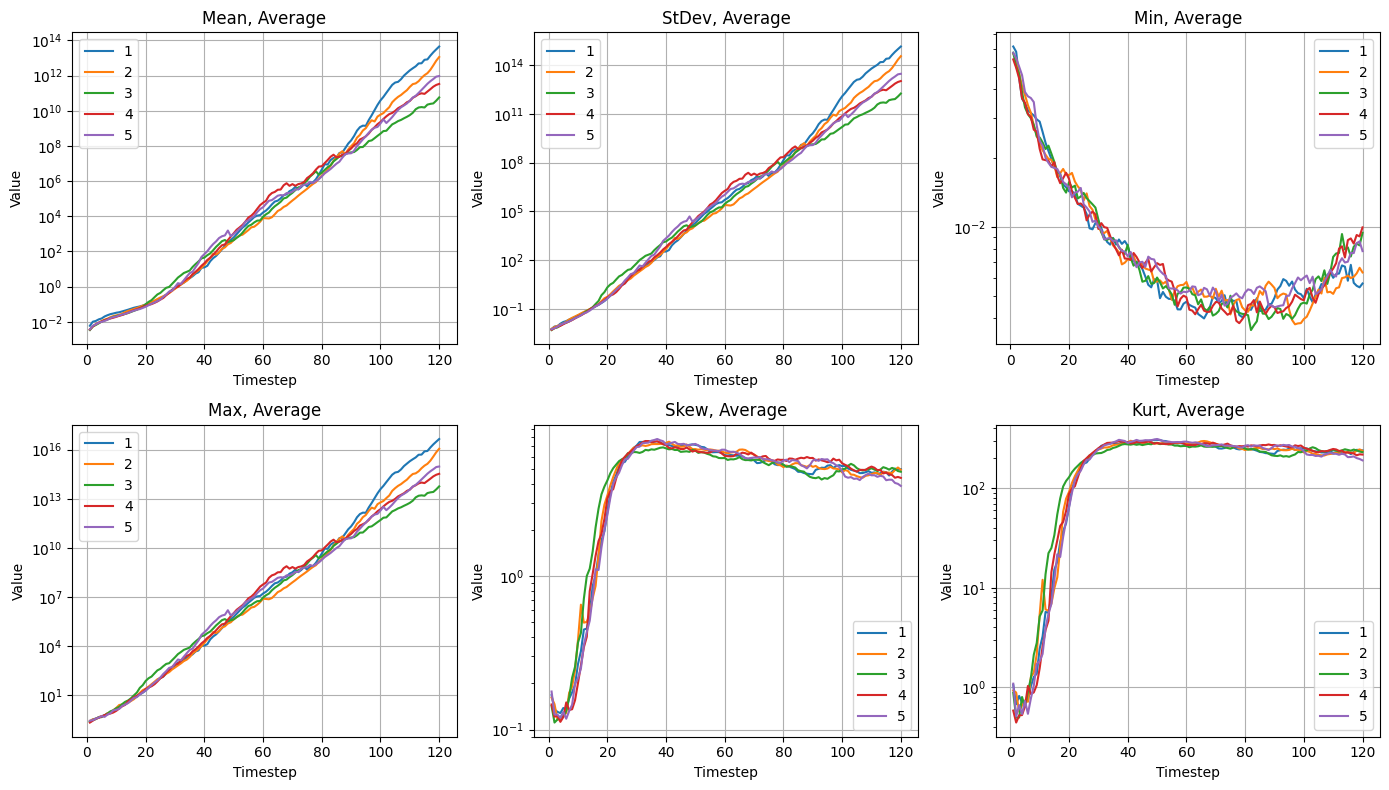

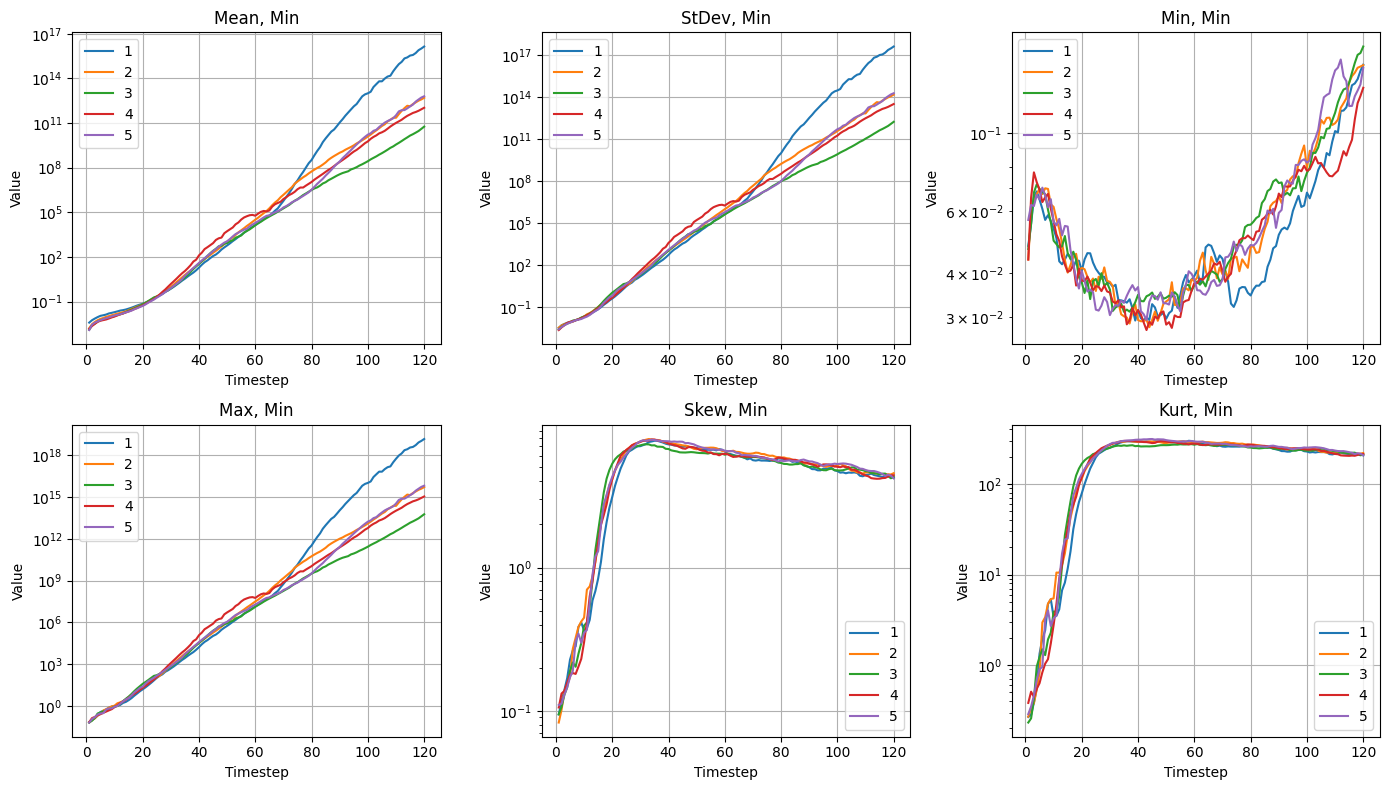

In [102]:
df_moments_mean = pd.DataFrame(columns=['Mean', 'StDev', 'Min', 'Max', 'Skew', 'Kurt'])
for i in ['E_USD', 'E_JPY', 'RiskyGenericBondPortfolio1'] + list(map(str, [i for i in range(1, 11, 1)])):
    plot_moments(i)
    #print(mean_moments(i))
    #df_moments_mean = pd.concat([df_moments_mean, mean_moments(i)], axis = 0, join = 'inner', copy = True)
    print('\n')
#df_moments_mean.to_csv('moments_mean.csv')

### Correlations Visualisation

In [31]:
def correlations_table(method):
    temp = pd.read_csv('Correlations_new' + method + '.csv')
    T = 60
    df = temp[temp['Timestep'] == T].copy()
    col1 = df['Output A'].unique()
    col2 = df['Output B'].unique()
    n = len(col1)
    res_mean = np.eye(n+1)
    res_std = np.zeros((n+1, n+1))
    for i in range(n):
        for j in range(i, n):
            x1, x2 = col1[i], col2[j]
            corr_mean = df[( df['Output A'] == x1 ) & ( df['Output B'] == x2 )][['Seed_num', 'Correlation']].mean()['Correlation']
            corr_std = df[( df['Output A'] == x1 ) & ( df['Output B'] == x2 )][['Seed_num', 'Correlation']].std()['Correlation']

            #print(i, j, x1.split('.')[-2], x2.split('.')[-2], corr, '\n')
            res_mean[i, j+1] = corr_mean
            res_mean[j+1, i] = corr_mean

            res_std[i, j+1] = corr_std
            res_std[j+1, i] = corr_std

    df = pd.DataFrame('', index = range(n+1), columns=range(n+1), dtype=str)

    for i in range(n+1):
        for j in range(n+1):
            df.loc[i, j] = str(round(res_mean[i, j], 2)) + ' (' + str(round(res_std[i, j], 2)) + ')'
    df = df.set_axis(['E_USD', 'E_JPY', 'Bond'] + list(map(str, [i for i in range(1, 11, 1)])), axis = 0)
    df = df.set_axis(['E_USD', 'E_JPY', 'Bond'] + list(map(str, [i for i in range(1, 11, 1)])), axis = 1)
    
    df.to_csv('Corr_matrix_' + method + '.csv')

for i in ['_False_None', '_True_None', '_False_Mean', '_False_MeanAndVariance', '_False_MeanVarianceAndAutoCorrelations']:
    correlations_table(i)

### Percentiles Visualisation

In [21]:
def mean_quantiles(name):
    q = ['0-1%', '1-5%', '5-50%', '50-95%', '95-99%']
    m = len(q)

    name_array = ['_False_None', '_True_None', '_False_Mean', '_False_MeanAndVariance', '_False_MeanVarianceAndAutoCorrelations']
    d = []
    for i in name_array: d.append(pd.read_csv('Percentiles_new/Percentiles' + name + i + '.csv'))

    res = []

    for i in range(m):

        d_seed = {}
        for j in range(len(name_array)):
            t = d[j].groupby('Timestep').mean()[q[i]].values
            d_seed[name_array[j]] = np.median(t)

        temp = sorted(d_seed.items(), key = lambda x: x[1], reverse = True)
        max_index, min_index = temp[0][0], temp[-1][0]
        a1 = d[name_array.index(max_index)].groupby('Timestep').mean()[q[i]].values
        a2 = d[name_array.index(min_index)].groupby('Timestep').mean()[q[i]].values
        
        if (np.argwhere(a1 == 0) == np.argwhere(a2 == 0)).all() == True: 
            a1, a2 = a1[a1 != 0], a2[a2 != 0] 
        else: 
            assert False, 'zeros are not in the same positions'
            
        res.append(np.mean(np.abs(a2 - a1) / np.maximum(np.abs(a1) , np.abs(a2)) ))
        
    #return a1, a2   
    return pd.DataFrame([res], columns=['1%', '5%', '50%', '95%', '99%'], index=[names_d[name]])

In [24]:
def plot_quantiles(name):
    m1, m2 = 1, 5
    fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(18, 4))
    axes = ax.flatten()

    q = ['0-1%', '1-5%', '5-50%', '50-95%', '95-99%']
    m = len(q)
    
    name_array = ['_False_None', '_True_None', '_False_Mean', '_False_MeanAndVariance', '_False_MeanVarianceAndAutoCorrelations']
    d = []
    for i in name_array: d.append(pd.read_csv('Percentiles_new/Percentiles' + name + i + '.csv'))
    
    k = 2
    for data_idx, i in enumerate(d):
        df = i.groupby('Timestep').std().reset_index().melt(id_vars='Timestep', var_name='Variable', value_name='std')
        
        
        for idx, j in enumerate(q):
            sns.lineplot(x = 'Timestep', y = 'std', data = df[df['Variable'] == j][k:], ax = axes[idx], label = data_idx+1)#name_array[data_idx][1:])
            
            axes[idx].set_title(j.split('-')[-1] + ', ' + names_d[name])
            axes[idx].set_xlabel('Timestep')
            axes[idx].set_ylabel('Value')
            axes[idx].legend()
            axes[idx].set_xticks(np.arange(0, 121, 20))
            axes[idx].grid()
            #axes[idx].set_yscale('log')
        
    plt.tight_layout()
    plt.savefig(name + 'percentiles.png')
    plt.show()

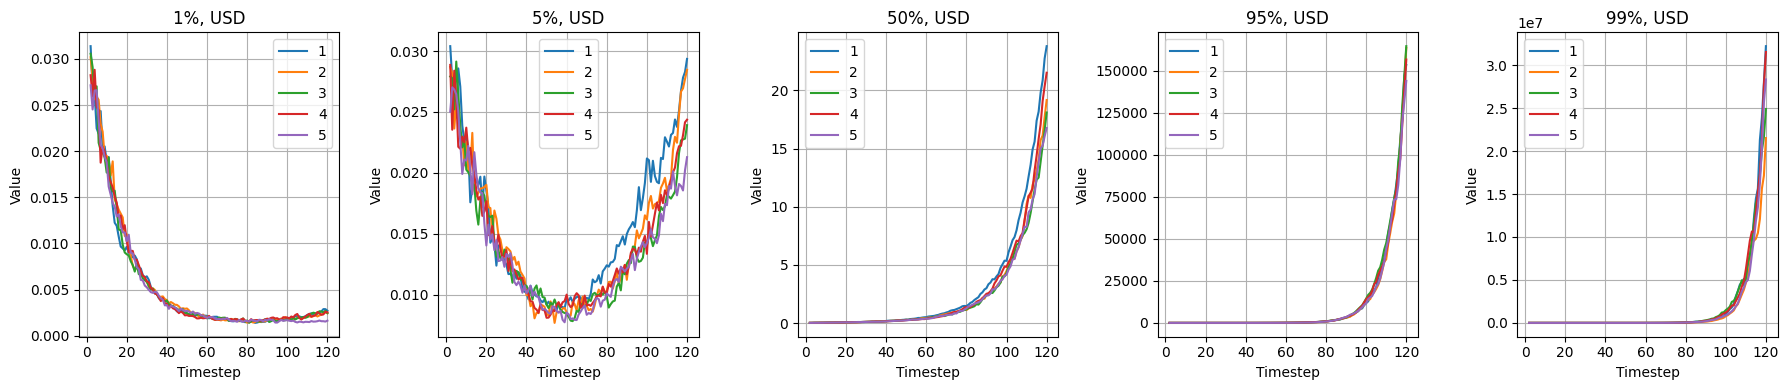

           1%        5%       50%       95%       99%
USD  0.038501  0.044485  0.006698  0.045125  0.110945




/var/folders/lf/4hrjtxjs6_jgqk2kmmcrdrx80000gn/T/ipykernel_48019/2645634673.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_perceniles_mean = pd.concat([df_perceniles_mean, mean_quantiles(i)], axis = 0, join = 'inner', copy = True)


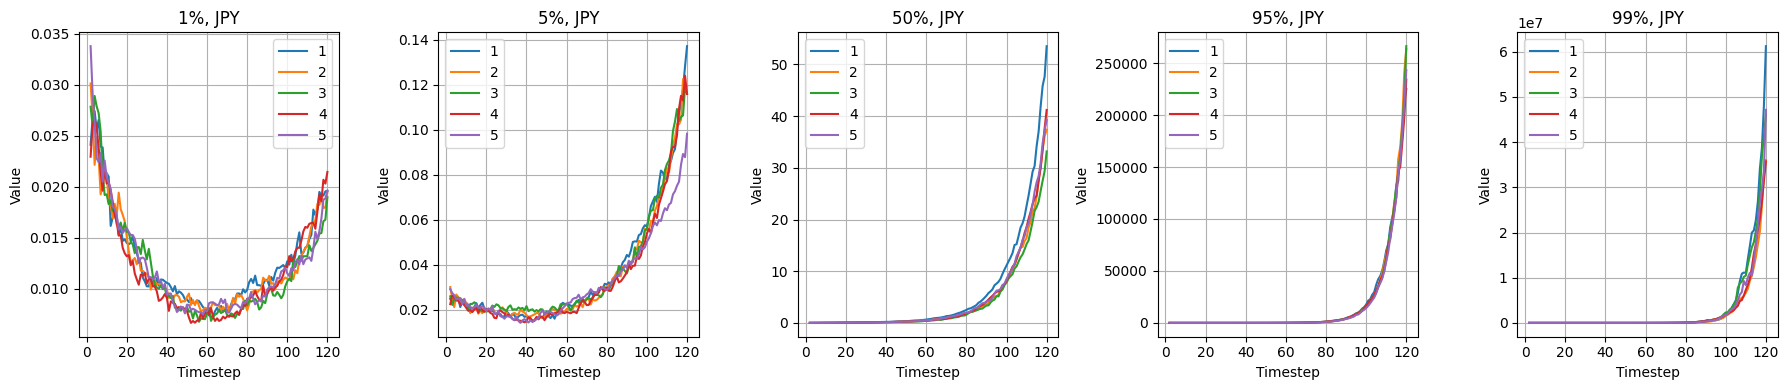

          1%        5%       50%       95%       99%
JPY  0.04924  0.024373  0.013324  0.036708  0.149744




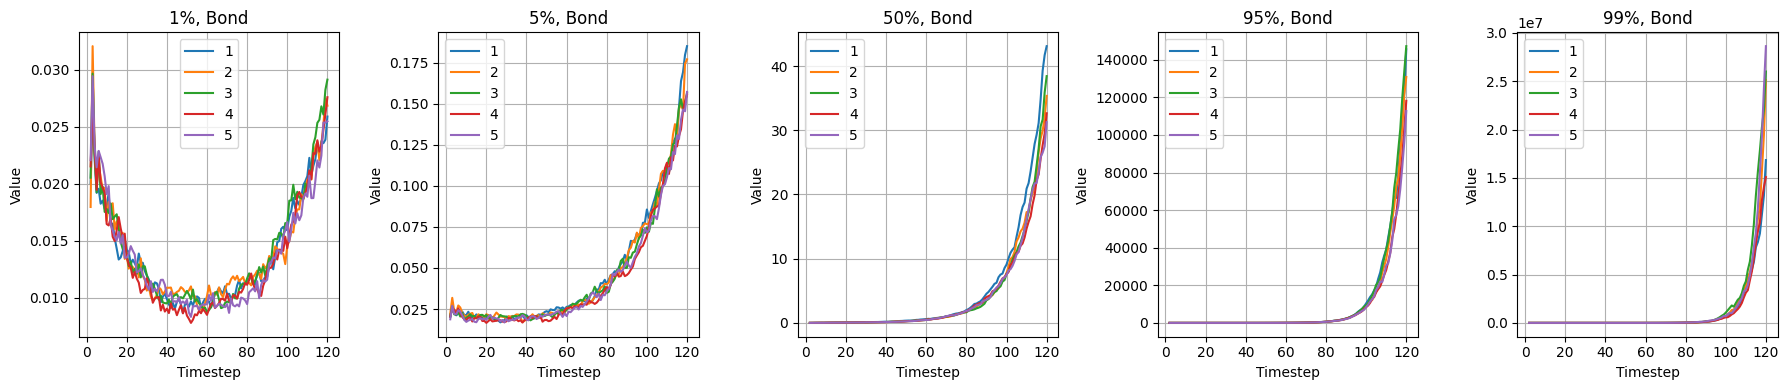

            1%        5%       50%       95%       99%
Bond  0.040777  0.026886  0.008345  0.011924  0.046753




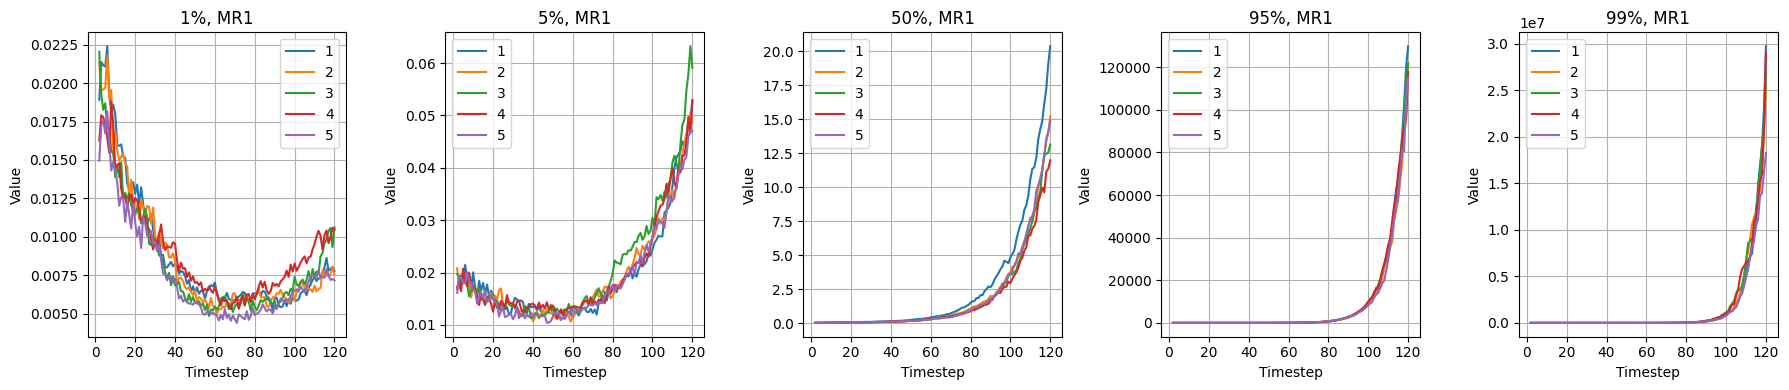

           1%        5%       50%       95%       99%
MR1  0.023345  0.016378  0.007117  0.047186  0.094175




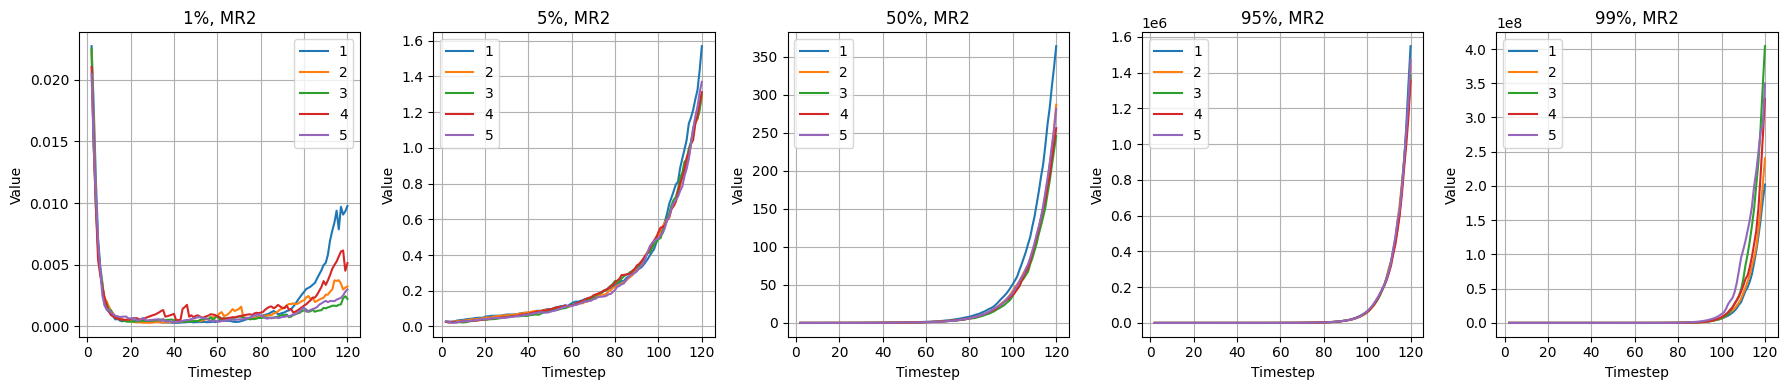

           1%        5%       50%       95%       99%
MR2  0.271814  0.037024  0.009128  0.012654  0.063574




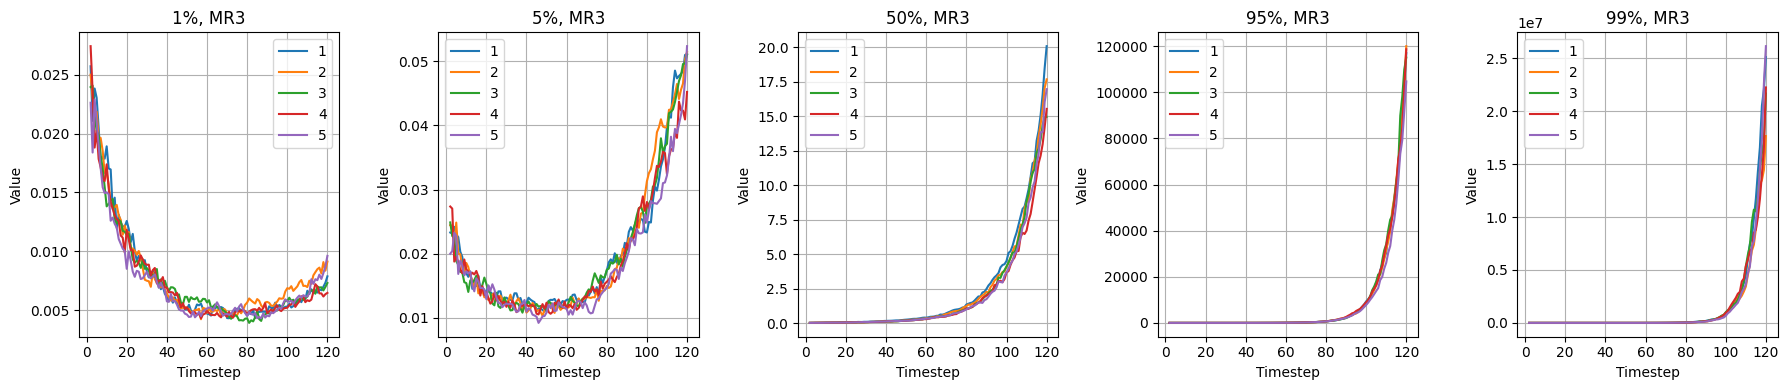

           1%        5%       50%       95%       99%
MR3  0.034555  0.032002  0.009536  0.032848  0.067067




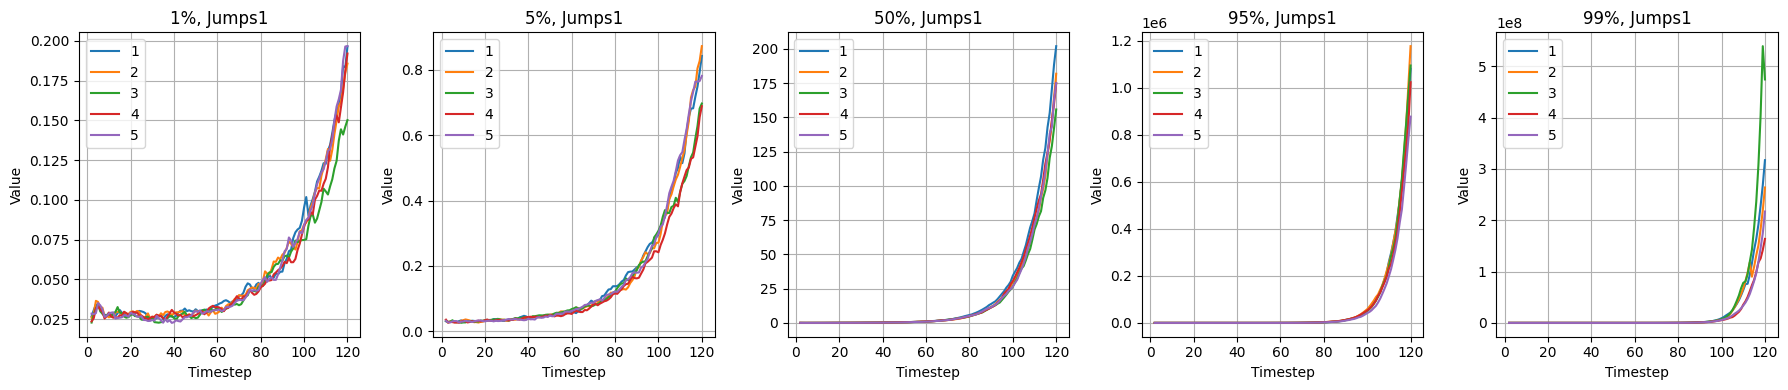

              1%        5%       50%       95%       99%
Jumps1  0.031983  0.015283  0.011356  0.019895  0.115792




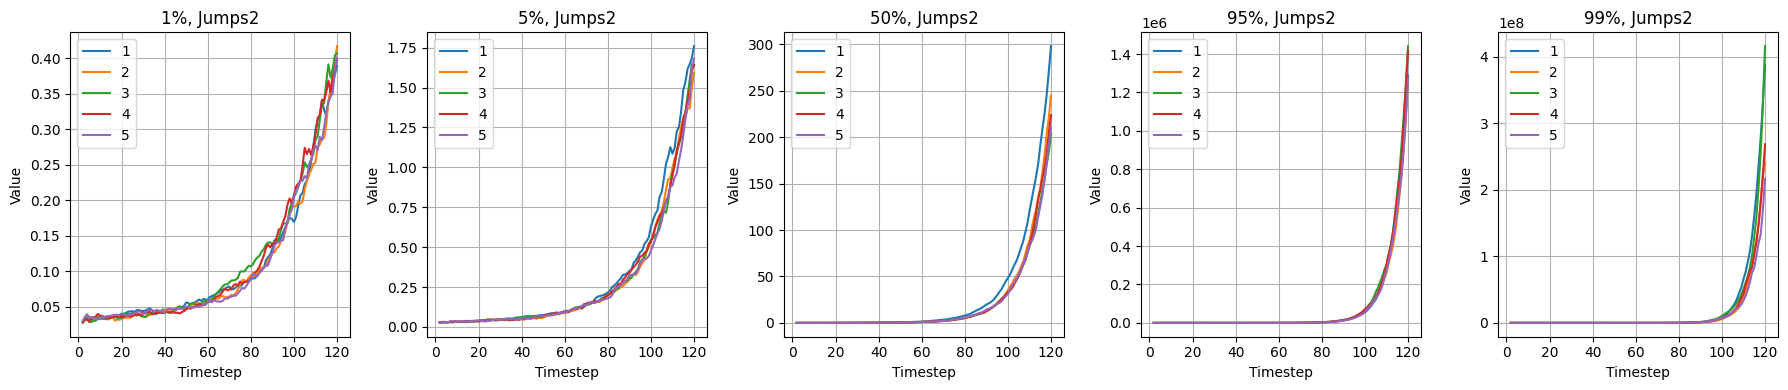

              1%        5%       50%       95%       99%
Jumps2  0.030846  0.022451  0.009324  0.033106  0.115156




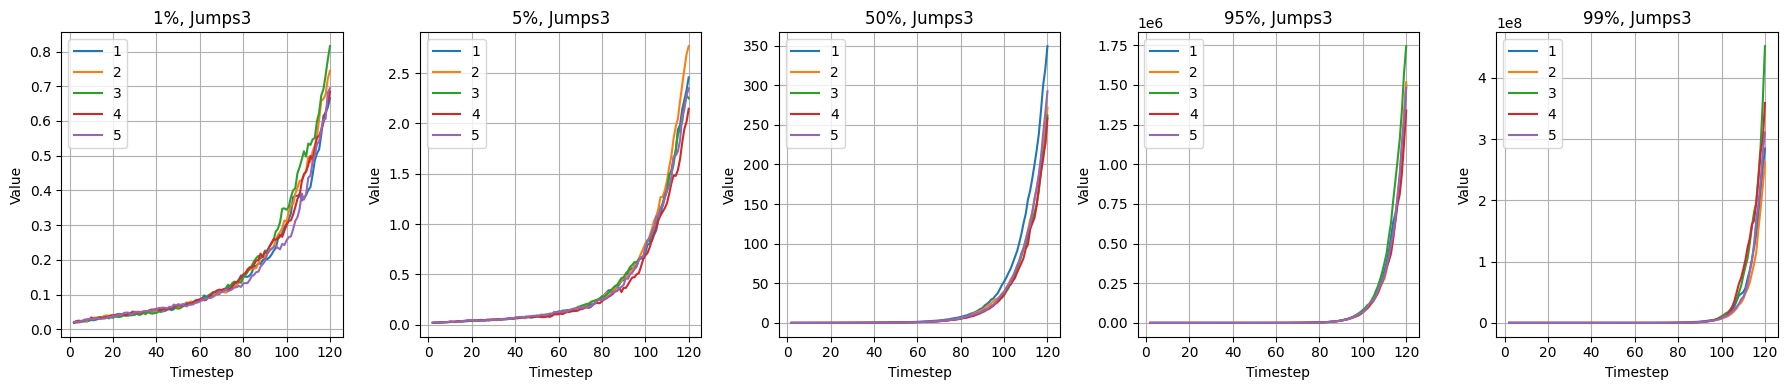

              1%        5%       50%       95%       99%
Jumps3  0.025904  0.025593  0.010259  0.028298  0.122801




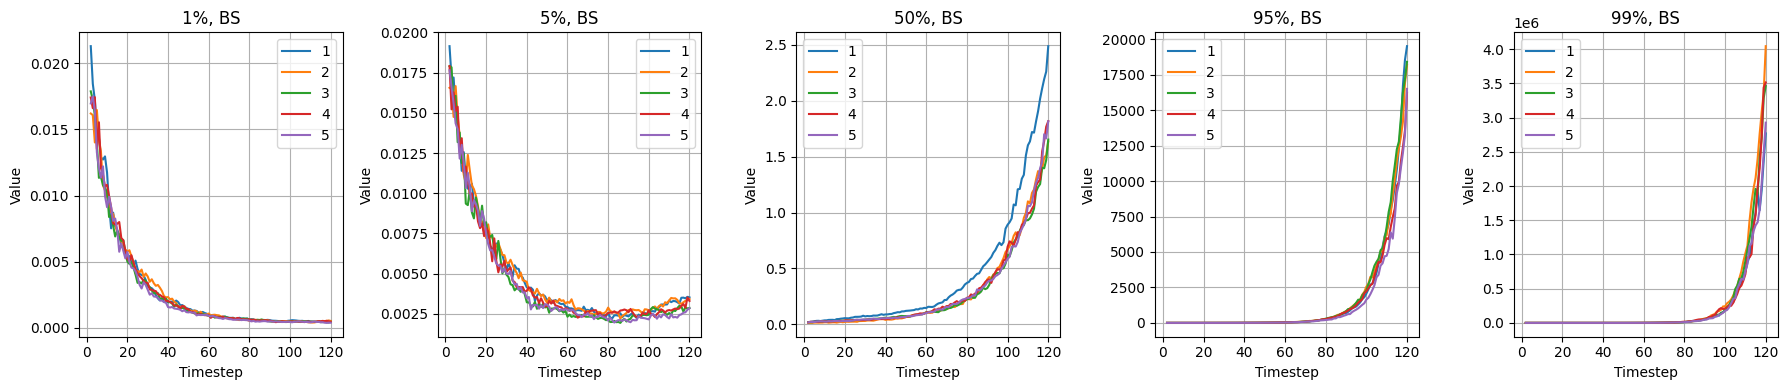

          1%        5%       50%       95%       99%
BS  0.035377  0.014632  0.007957  0.021297  0.048015




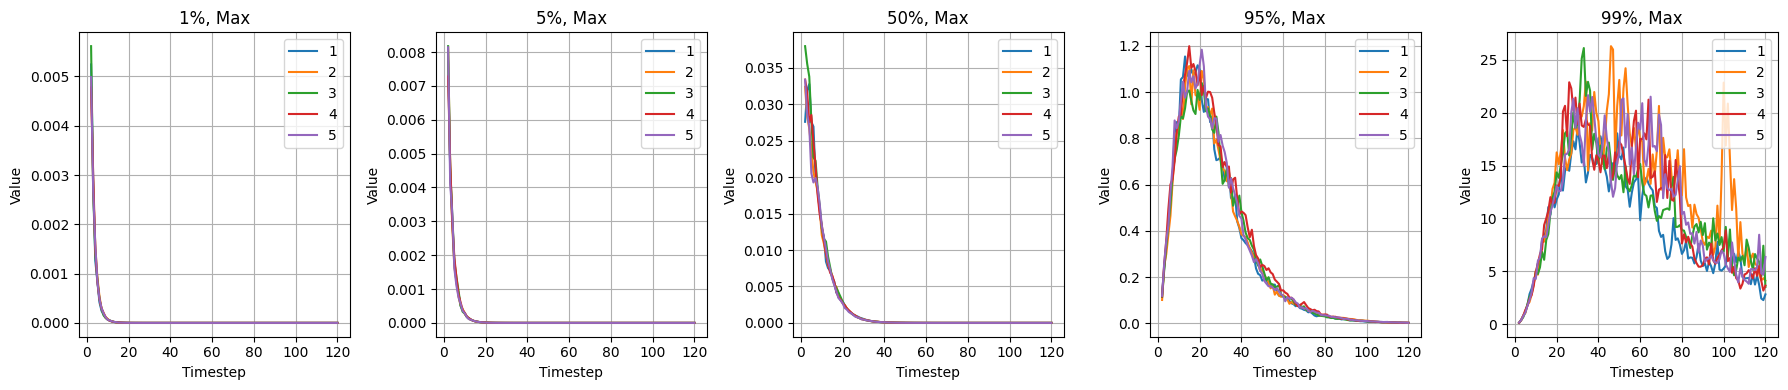

           1%        5%       50%       95%       99%
Max  0.156211  0.064699  0.048739  0.040852  0.150001




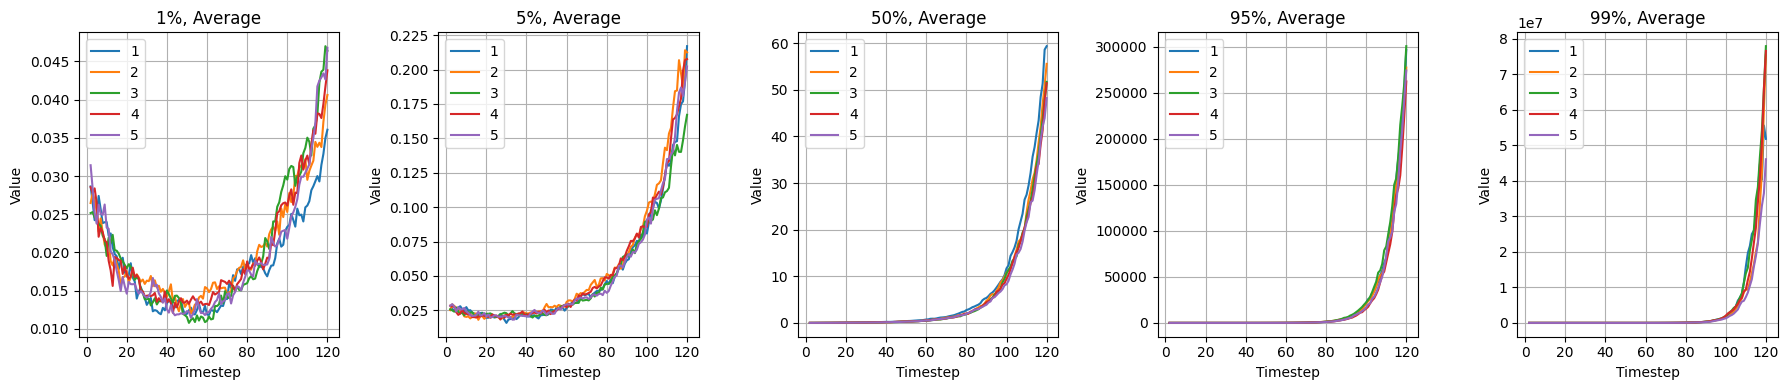

               1%        5%       50%       95%       99%
Average  0.023875  0.020129  0.012805  0.041596  0.079752




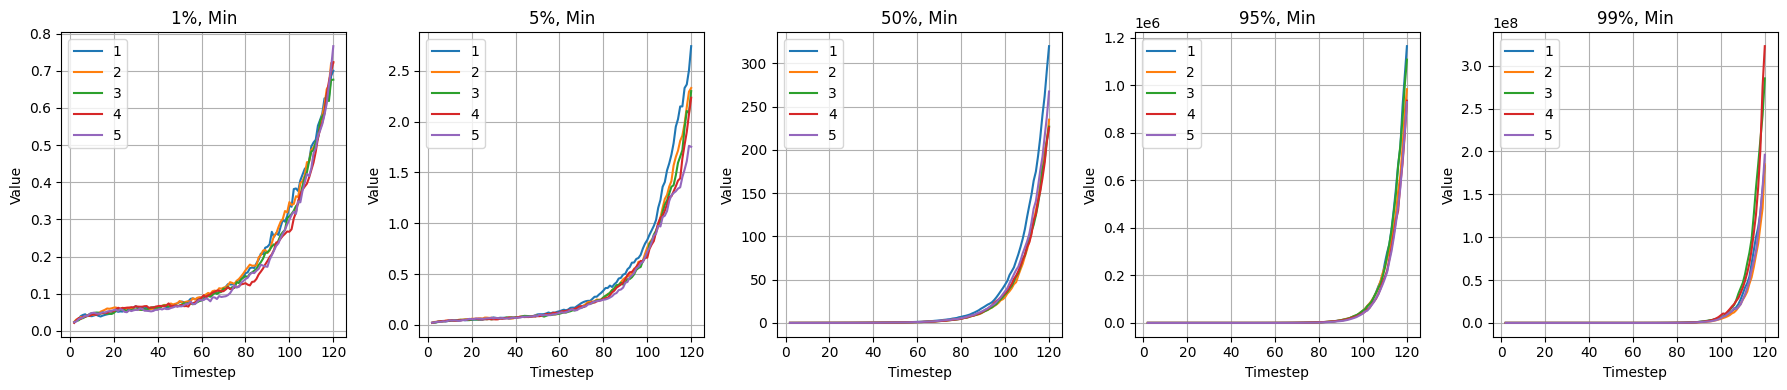

           1%        5%       50%       95%     99%
Min  0.037999  0.015831  0.009998  0.030476  0.1364




In [25]:
df_perceniles_mean = pd.DataFrame(columns=['1%', '5%', '50%', '95%', '99%'])
for i in ['E_USD', 'E_JPY', 'RiskyGenericBondPortfolio1'] + list(map(str, [i for i in range(1, 11, 1)])):
    plot_quantiles(i)
    print(mean_quantiles(i))
    df_perceniles_mean = pd.concat([df_perceniles_mean, mean_quantiles(i)], axis = 0, join = 'inner', copy = True)
    print('\n')
df_perceniles_mean.to_csv('perceniles_mean.csv')

In [18]:

df2 = pd.read_pickle('data.pkl')

In [56]:
df2

ESG.Assets.EquityAssets.7.TotalReturnIndex  \
0                                           1.000000   
1                                           0.968015   
2                                           0.756717   
3                                           0.502052   
4                                           0.415186   
...                                              ...   
12099995                                    0.136023   
12099996                                    0.171562   
12099997                                    0.146259   
12099998                                    0.131466   
12099999                                    0.104764   

          ESG.Assets.EquityAssets.7.ExcessReturnIndex  Seed_num Trial Timestep  
0                                            1.000000         1     1        0  
1                                            0.923968         1     1        1  
2                                            0.712922         1     1        2  
3                                            0.468242         1     1        3  
4                                            0.380590         1     1        4  
...                                               ...       ...   ...      ...  
12099995                                     0.000288       100  1000      116  
12099996                                     0.000346       100  1000      117  
12099997                                     0.000280       100  1000      118  
12099998                                     0.000238       100  1000      119  
12099999                                     0.000179       100  1000      120  

[12100000 rows x 5 columns]

In [57]:
df2.sort_values(by = ['Timestep', 'Trial'], inplace = True, ignore_index = True)

In [58]:
#df2.groupby('Timestep').mean()['ESG.Assets.EquityAssets.7.ExcessReturnIndex'].reset_index()
df3 = df2.groupby(['Seed_num', 'Timestep']).mean()['ESG.Assets.EquityAssets.7.ExcessReturnIndex'].reset_index()

In [59]:
df3.groupby('Seed_num').describe()['ESG.Assets.EquityAssets.7.ExcessReturnIndex']['mean'].idxmax()

89

In [38]:
df_max = df3[df3['Seed_num'] == 89][['Timestep', 'ESG.Assets.EquityAssets.7.ExcessReturnIndex']]
df_max.rename(columns = {'ESG.Assets.EquityAssets.7.ExcessReturnIndex': 'bs'}, inplace = True)

In [39]:
df_max

Timestep        bs
10648         0  1.000000
10649         1  0.999617
10650         2  0.996797
10651         3  1.013125
10652         4  1.025364
...         ...       ...
10764       116  6.880665
10765       117  5.775406
10766       118  4.482722
10767       119  4.075128
10768       120  3.394410

[121 rows x 2 columns]

In [4]:
df = pd.read_csv('BS_max.csv', index_col = False)
df.head()

Trial  Timestep  ESG.Assets.EquityAssets.7.TotalReturnIndex
0      1         0                                    1.000000
1      1         1                                    1.278164
2      1         2                                    1.909984
3      1         3                                    2.516226
4      1         4                                    2.639431

In [5]:
df = df[['Trial', 'Timestep', 'ESG.Assets.EquityAssets.7.TotalReturnIndex']]
df.rename(columns = {'ESG.Assets.EquityAssets.7.TotalReturnIndex': 'traj'}, inplace = True)

In [6]:
df_martingale = df.groupby('Timestep').mean()['traj'].reset_index()
df_martingale.rename(columns = {'traj': 'BS'}, inplace = True)

In [8]:
df.sort_values(by = ['Timestep', 'Trial'], inplace = True, ignore_index = True)

In [9]:
df_all = pd.read_csv('BS_traj_all.csv', index_col = False)
#df_all = df_all[['Trial', 'Timestep', 'ESG.Assets.EquityAssets.7.TotalReturnIndex']]
df_all.rename(columns = {'ESG.Assets.EquityAssets.7.TotalReturnIndex': 'traj'}, inplace = True)

In [10]:
df_martingale_all = df_all.groupby(['Seed_num', 'Timestep']).mean()['traj'].reset_index()
df_martingale_all.rename(columns = {'traj': 'BS'}, inplace = True)
df_martingale_all.head()

Seed_num  Timestep        BS
0         1         0  1.000000
1         1         1  1.010274
2         1         2  1.016700
3         1         3  1.016660
4         1         4  1.012722

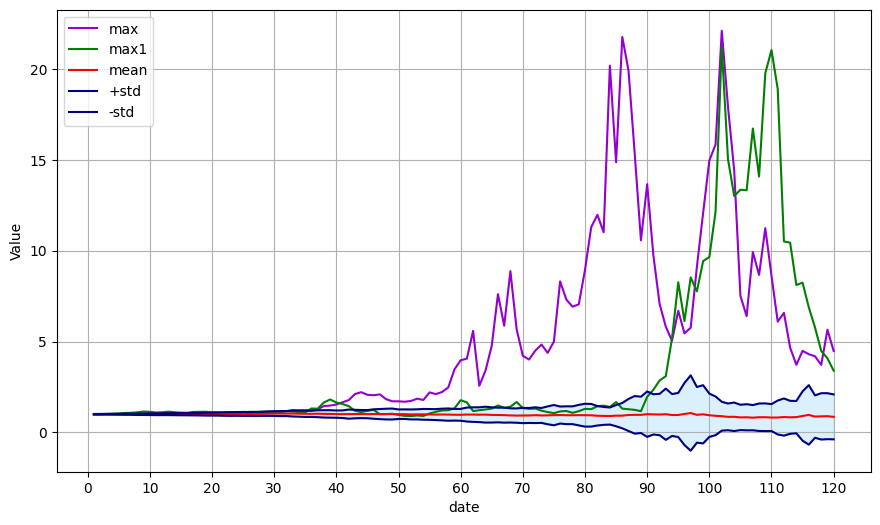

In [40]:
x = df_martingale['Timestep'].values[1:]
mean_seed = df_martingale_all.groupby('Timestep').mean()['BS'].values
std = df_martingale_all.groupby('Timestep').std()['BS'].values

fig, ax = plt.subplots()  

sns.lineplot(x = x, y = df_martingale['BS'].values[1:], color = 'darkviolet', label = 'max')
sns.lineplot(x = x, y = df_max['bs'].values[1:], color = 'green', label = 'max1')

#sns.lineplot(x = x, y = 1.0, color = 'fuchsia')
sns.lineplot(x = x, y = mean_seed[1:], label = 'mean', color = 'red')    
sns.lineplot(x = x, y = mean_seed[1:] + std[1:] , label = '+std', color = 'navy')
a = sns.lineplot(x = x, y = mean_seed[1:] - std[1:] , label = '-std', color = 'navy')

line = a.get_lines()
plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)
#sns.lineplot(x = x, y = new_mart[1:], color = 'green')
#sns.lineplot(x = x, y = (y @ W_mean).flatten()[1:], color = 'gold')
#sns.lineplot(x = x, y = list(map(lambda x: x * 1, l1_error)), color = 'green')


plt.xlabel('date')
plt.ylabel('Value')
fig.set_figheight(6)
fig.set_figwidth(10.5)

#ax.set_yscale('log')

plt.xticks(np.arange(0, x.max()+1, 10))
plt.grid()

plt.savefig('BS_mart_traj.png')
plt.show() 

In [165]:
n = len(df[df['Timestep'] == 0]['traj'].values)
S = df['traj'].values.reshape(121, n)
l = 4.0

start = time()
x = cp.Variable(n)
starting_value = np.ones(n) / n  #x0 = equal weights
x.value = starting_value

prob = cp.Problem(cp.Minimize( cp.square(cp.norm(S @ x - 1.0, 2)) / n + l * cp.square(cp.norm(x - 1/n, 2)) ), [x >= 0, cp.sum(x) == 1])
prob.solve()
end = time()
print(end - start)

0.22281789779663086


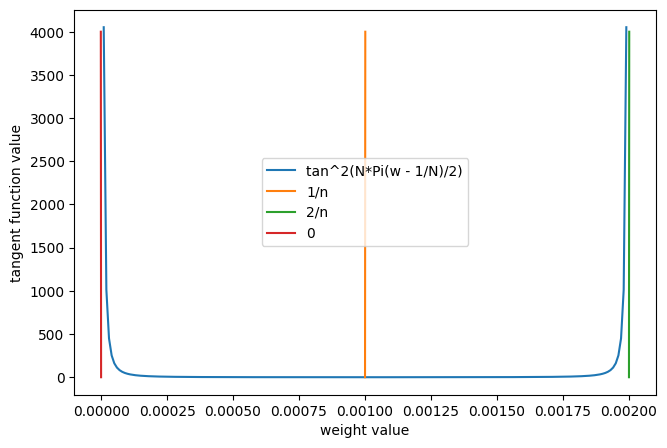

In [68]:
x = np.arange(1e-18, (2/n)+1e-18, 0.01/n)[1:]
y = [math.tan(n * (i - 1/n) * 0.5 * math.pi) ** 2 for i in x]


fig, ax = plt.subplots()
sns.lineplot(x = x, y = y, label = 'tan^2(N*Pi(w - 1/N)/2)')
sns.lineplot(x = [1/n, 1/n+1e-6], y = [0, 4000], label = '1/n')
sns.lineplot(x = [2/n, 2/n+1e-6], y = [0, 4000], label = '2/n')
sns.lineplot(x = [0/n, 0/n-1e-6], y = [0, 4000], label = '0')
# sns.lineplot(x = x_a, y = 2/n, label = '2/n')
# sns.lineplot(x = x_a, y = 0, label = '0')
plt.xlabel('weight value')
plt.ylabel('tangent function value')
fig.set_figheight(5)
fig.set_figwidth(7.5)
plt.legend()
plt.savefig('tan^2.png')
plt.show()

In [63]:
n = len(df[df['Timestep'] == 0]['traj'].values)
S = df['traj'].values.reshape(121, n)
S = df2[df2['Seed_num'] == 89]['ESG.Assets.EquityAssets.7.ExcessReturnIndex'].values.reshape(121, n)
#l = 8/n**2
#l = 2**4/n**2
l = 8e-6

start = time()
# Objective function to minimize
def objective(x, S, n, l):
    term1 = np.linalg.norm(S @ x - 1.0)**2 / n
    
    if (x > 2/n).any() == True or (x < 0).any() == True:
        term2 = 1e+30
    else:  
        #term2 = l * np.linalg.norm(x - 1/n)**2
        term2 = l *  np.linalg.norm( np.tan(n * (x - 1/n) * 0.5 * math.pi) )**2 
    return term1 + term2

# Constraints
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]#,  # sum(x) == 1
               #{'type': 'ineq', 'fun': lambda x: x}]            # x >= 0

# Initial guess
x0 = np.ones(n) / n  # equal weights

# Solve the optimization problem
result = minimize(objective, x0, args=(S, n, l), constraints=constraints, method = 'SLSQP', options={'maxiter': 100})

# Optimized x
x_optimized = result.x

end = time()
print(end - start)

72.34737992286682


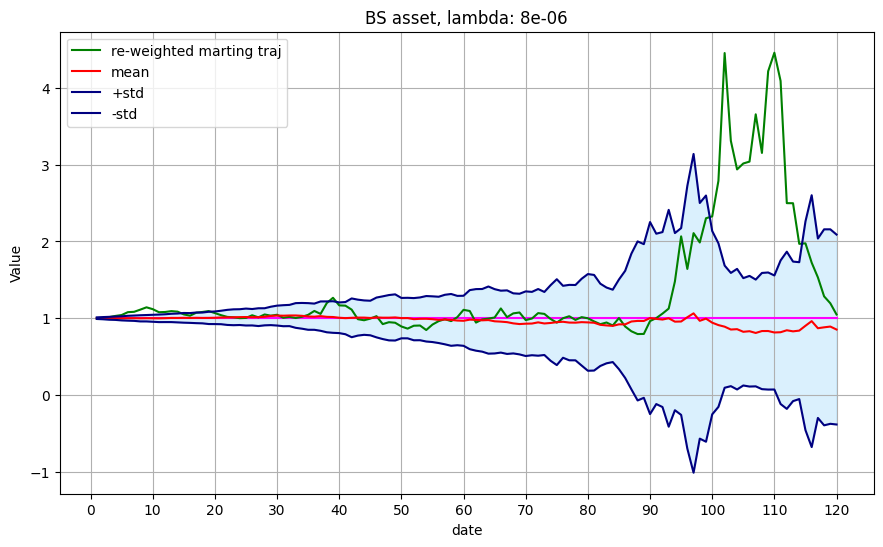

In [64]:
    new_mart = S @ result.x.reshape(1000, -1).flatten()

    x = df_martingale['Timestep'].values[1:]

    mean_seed = df_martingale_all.groupby('Timestep').mean()['BS'].values
    std = df_martingale_all.groupby('Timestep').std()['BS'].values

    fig, ax = plt.subplots()  

    sns.lineplot(x = x, y = 1.0, color = 'fuchsia')
    sns.lineplot(x = x, y = new_mart[1:], color = 'green', label = 're-weighted marting traj')
    sns.lineplot(x = x, y = mean_seed[1:], color = 'red', label = 'mean')    
    sns.lineplot(x = x, y = mean_seed[1:] + std[1:] , label = '+std', color = 'navy')
    a = sns.lineplot(x = x, y = mean_seed[1:] - std[1:] , label = '-std', color = 'navy')
    line = a.get_lines()
    plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)
    ax.set_title('BS asset, lambda: ' + str(l))
    plt.xlabel('date')
    plt.ylabel('Value')
    fig.set_figheight(6)
    fig.set_figwidth(10.5)
    plt.xticks(np.arange(0, x.max()+1, 10))
    plt.grid()
    #plt.savefig('BS_opt_traj.png')
    plt.show()

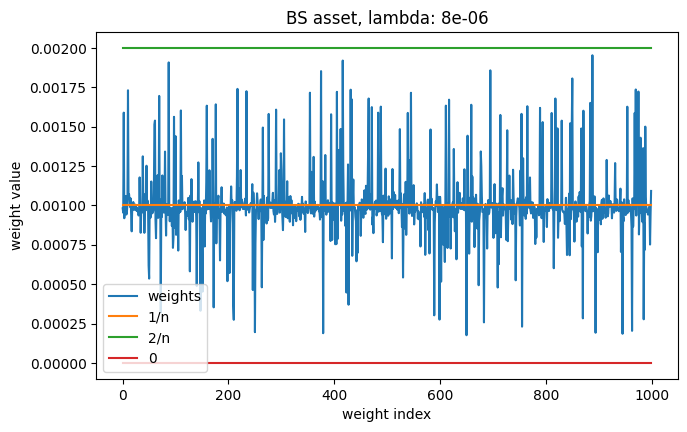

In [65]:
    fig, ax = plt.subplots()

    x_a = np.arange(0, 1000, 1)

    sns.lineplot(x = x_a, y = result.x, label = 'weights')
    sns.lineplot(x = x_a, y = 1/n, label = '1/n')
    sns.lineplot(x = x_a, y = 2/n, label = '2/n')
    sns.lineplot(x = x_a, y = 0, label = '0')
    ax.set_title('BS asset, lambda: ' + str(l))
    plt.xlabel('weight index')
    plt.ylabel('weight value')
    fig.set_figheight(4.5)
    fig.set_figwidth(7.5)
    plt.legend()
    #plt.savefig('BS_opt_w.png')
    plt.show()

In [20]:
result

 message: Iteration limit reached
 success: False
  status: 9
     fun: 0.005077386238599555
       x: [ 1.050e-03  1.018e-03 ...  1.027e-03  1.004e-03]
     nit: 100
     jac: [ 1.815e-03  6.604e-04 ...  6.826e-04 -5.772e-04]
    nfev: 100364
    njev: 100

In [18]:
max(S @ x_optimized.reshape(n, -1).flatten())

1.5584358522729933

In [41]:
l

1.6e-05

In [11]:
from scipy.optimize import minimize

In [12]:
def wecdf(x, w, t):
    n = len(x)
    res = 0
    for i in range(n):
        if x[i] <= t:
            res += w[i]
    return res

In [13]:
def objective(x, S, n, l):
    term1 = np.linalg.norm(S @ x - 1.0)**2 / n
    
    if (x > 2/n).any() == True or (x < 0).any() == True:
        term2 = 1e+30
    else:  
        #term2 = l * np.linalg.norm(x - 1/n)**2
        term2 = l *  np.linalg.norm( np.tan(n * (x - 1/n) * 0.5 * math.pi) )**2 
    return term1 + term2

constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]#,  # sum(x) == 1
               #{'type': 'ineq', 'fun': lambda x: x}]            # x >= 0

# Initial guess
#x0 = np.ones(n) / n  # equal weights

In [14]:
def percentile_w(X, percents, weights=None):
    ''' percents in units of 1%'''

    if weights is None:
        return np.percentile(X, percents)
    
    ind = np.argsort(X)
    Y = X[ind]
    w = weights[ind]
    p = 1.*w.cumsum()/w.sum()*100
    res = np.interp(percents, p, Y)
    return res

In [15]:
def moment_w(X, w):
    X = X[1:]
    n = len(X)
    
    mean_w = (X @ w).reshape(n, 1)
    var_w = (X - mean_w) ** 2 @ w
    skew_w = ((X - mean_w)**3 @ w) / var_w ** 1.5
    kurt_w = ((X - mean_w)**4 @ w) / var_w ** 2 - 3.0
    
    return [mean_w.flatten(), var_w ** 0.5, skew_w, kurt_w]

0 lambda:  2e-06


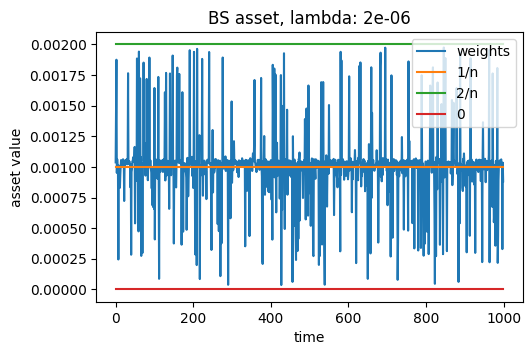

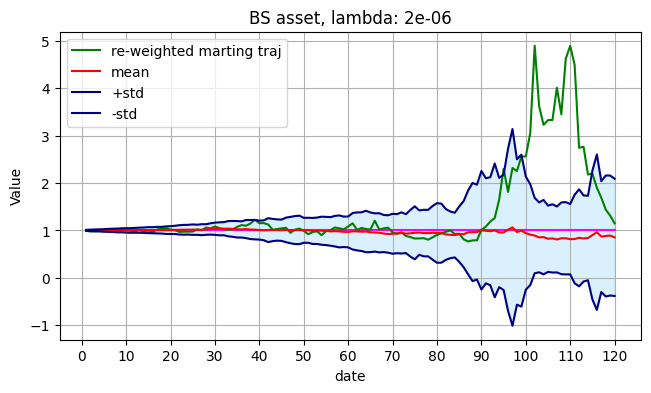

/var/folders/lf/4hrjtxjs6_jgqk2kmmcrdrx80000gn/T/ipykernel_7077/3018405189.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_valid_m = pd.concat([df_valid_m, df_test], ignore_index=True)




1 lambda:  4e-06


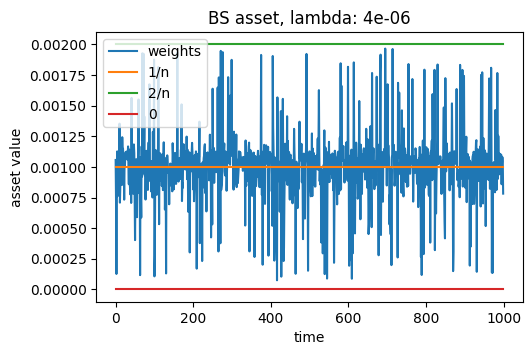

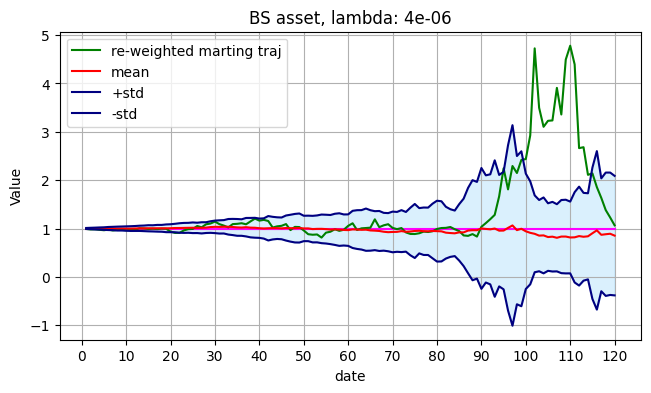



2 lambda:  6e-06


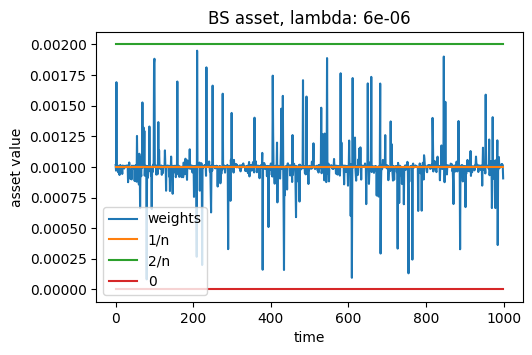

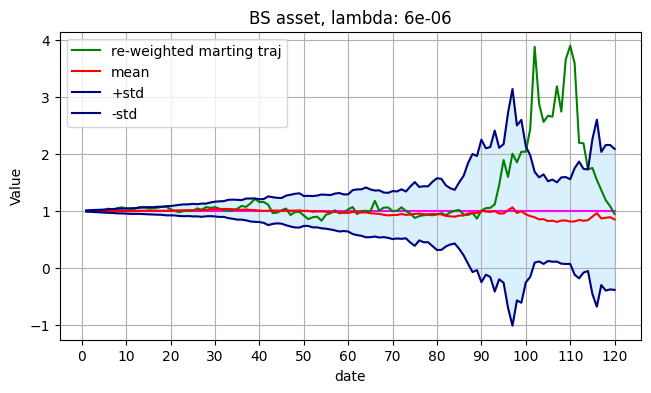



3 lambda:  8e-06


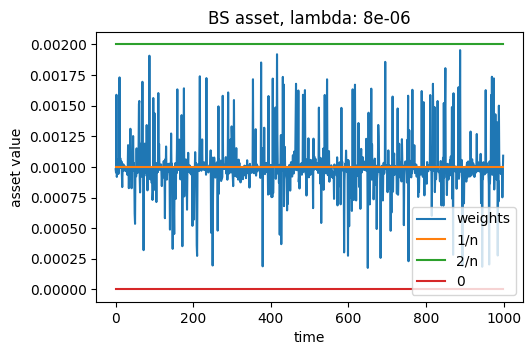

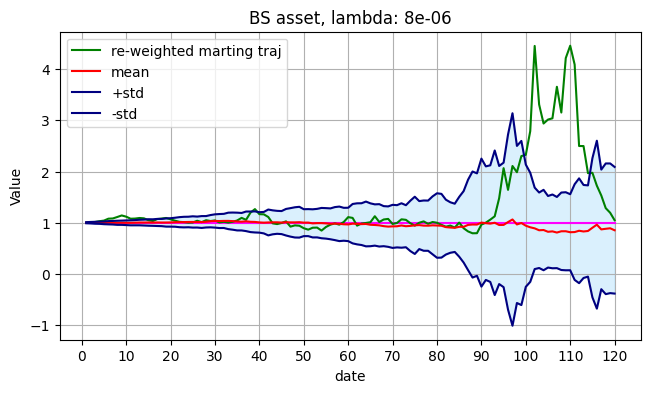



4 lambda:  9.999999999999999e-06


KeyboardInterrupt: 

In [68]:
n = len(df[df['Timestep'] == 0]['traj'].values)
S = df['traj'].values.reshape(121, n)
S = df2[df2['Seed_num'] == 89]['ESG.Assets.EquityAssets.7.ExcessReturnIndex'].values.reshape(121, n)
l = 1 / (n**2)

x_a = np.arange(0, 1000, 1)
p = [1, 5, 50, 95, 99]

E = 0
eps = 0.02
#eps = 0.01

count = 0

start = time()

#KS_arr, l_arr, maxdev_arr = [], [], []

df_stat = pd.DataFrame(columns = ['L', 'KS', 'M_max', 'W_aver', 'W_max'])
df_valid_m = pd.DataFrame(columns = ['Mean', 'Std', 'Skew', 'Kurt'])
df_valid_p = pd.DataFrame(columns = ['1', '5', '50', '95', '99'])

#for l in [i * 1/n**2 for i in range(1, 31, 1)]:#range(15):
#while E < 0.5:
#for _ in range(2):
for l in [i * 2e-6 for i in range(1, 16,1)]:
    
    #l *= 2
    print(count, 'lambda: ' , l )
    
    x0 = np.ones(n) / n
    result = minimize(objective, x0, args=(S, n, l), constraints=constraints, method = 'SLSQP', options={'maxiter': 100})
    
    fig, ax = plt.subplots()

    x_a = np.arange(0, 1000, 1)

    sns.lineplot(x = x_a, y = result.x, label = 'weights')
    sns.lineplot(x = x_a, y = 1/n, label = '1/n')
    sns.lineplot(x = x_a, y = 2/n, label = '2/n')
    sns.lineplot(x = x_a, y = 0, label = '0')
    ax.set_title('BS asset, lambda: ' + str(l))
    plt.xlabel('time')
    plt.ylabel('asset value')
    fig.set_figheight(3.5)
    fig.set_figwidth(5.5)
    plt.legend()
    plt.show()
    
    new_mart = S @ result.x.reshape(1000, -1).flatten()

    x = df_martingale['Timestep'].values[1:]

    mean_seed = df_martingale_all.groupby('Timestep').mean()['BS'].values
    std = df_martingale_all.groupby('Timestep').std()['BS'].values

    fig, ax = plt.subplots()  

    sns.lineplot(x = x, y = 1.0, color = 'fuchsia')
    sns.lineplot(x = x, y = new_mart[1:], color = 'green', label = 're-weighted marting traj')
    sns.lineplot(x = x, y = mean_seed[1:], color = 'red', label = 'mean')    
    sns.lineplot(x = x, y = mean_seed[1:] + std[1:] , label = '+std', color = 'navy')
    a = sns.lineplot(x = x, y = mean_seed[1:] - std[1:] , label = '-std', color = 'navy')
    line = a.get_lines()
    plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)
    ax.set_title('BS asset, lambda: ' + str(l))
    plt.xlabel('date')
    plt.ylabel('Value')
    fig.set_figheight(4)
    fig.set_figwidth(7.5)
    plt.xticks(np.arange(0, x.max()+1, 10))
    plt.grid()
    plt.show() 

    
    df_test = pd.DataFrame(data = moment_w(S, result.x)).T
    df_test.columns = ['Mean', 'Std', 'Skew', 'Kurt']
    df_valid_m = pd.concat([df_valid_m, df_test], ignore_index=True)
      
    for i in S:
        p_arr = []
        for j in range(len(p)):
            p_arr.append(percentile_w(i, p[j], result.x))
        df_valid_p.loc[len(df_valid_p.index)] = p_arr
    
    
    temp = df[df['Timestep'] == 100]['traj'].values
    x_aa = sorted(temp)
    y_a = norm.cdf(np.log(x_aa), loc = (0.0 - 0.5 * 0.1) * 100, scale = (0.1 * 100)**0.5)
    y_e = scipy.stats.ecdf(x_aa).cdf.probabilities
    y_ew = []
    weights = result.x
    for j in x_aa:
        y_ew.append(wecdf(temp, weights, j))
        
    KS = np.max(np.abs(np.array(y_ew) - y_e))
    MM = np.max(np.abs(S @ result.x.reshape(1000, -1).flatten() - 1.0))
    WA = np.mean(np.abs(result.x - 1/n))
    WM = np.max(np.abs(result.x - 1/n))
    
    df_stat.loc[len(df_stat.index)] = [l, KS, MM, WA, WM]
    
    E = MM

    #maxdev_arr.append(np.max(np.abs(S @ result.x.reshape(1000, -1).flatten() - 1.0)))
    #KS_arr.append(E)
    #l_arr.append(l)
    #print('K-S stat:', E)

#     fig, ax = plt.subplots()
#     sns.lineplot(x = x_aa, y = y_a, label = 'cdf_a')
#     sns.lineplot(x = x_aa, y = y_e, label = 'cdf_e')
#     sns.lineplot(x = x_aa, y = y_ew, label = 'cdf_eW')
#     plt.xlabel('Value')
#     plt.ylabel('cdf')
#     ax.set_xscale('log')
#     fig.set_figheight(3)
#     fig.set_figwidth(4.5)
#     plt.legend()
#     plt.show()

    print('\n')

#     fig, ax = plt.subplots()
#     error1 = np.abs(y_e - y_a)
#     error2 = np.abs(np.array(y_ew) - y_a)
#     sns.lineplot(x = x_aa, y = error1, label = 'E-A')
#     sns.lineplot(x = x_aa, y = error2, label = 'EW-A') 
#     plt.xlabel('Value')
#     plt.ylabel('error value')
#     ax.set_xscale('log')
#     fig.set_figheight(3)
#     fig.set_figwidth(4.5)
#     plt.legend()
#     plt.show()
    count += 1

df_valid_m['L'] = np.repeat(df_stat['L'].values, 120)
df_valid_p['L'] = np.repeat(df_stat['L'].values, 121)
end = time()
print(end - start)

In [69]:
df_stat

L        KS     M_max    W_aver     W_max
0  0.000002  0.011804  3.893600  0.000157  0.000975
1  0.000004  0.005553  3.780271  0.000186  0.000966
2  0.000006  0.004490  2.897200  0.000064  0.000949
3  0.000008  0.005131  3.455226  0.000118  0.000954

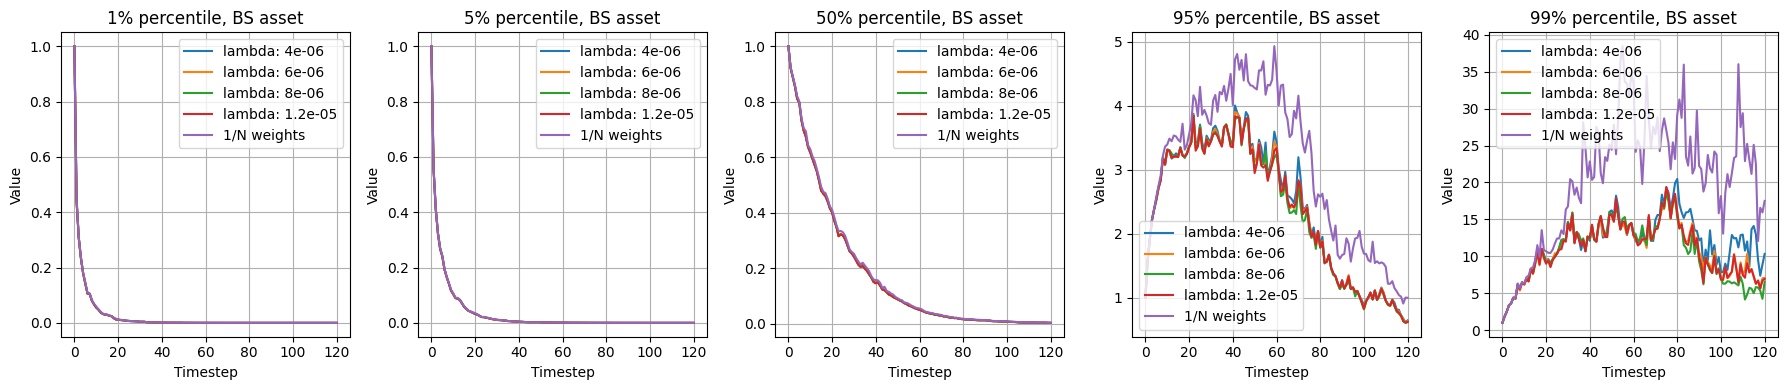

In [99]:
x = np.arange(0, 121, 1)
l_arr = df_stat['L'].values[1:5]
base = {0: np.percentile(a = S, q = 1, axis = 1, method = 'linear'), 1: np.percentile(a = S[:], q = 5, axis = 1, method = 'linear'), 
       2: np.percentile(a = S[:], q = 50, axis = 1, method = 'linear'), 3: np.percentile(a = S[:], q = 95, axis = 1, method = 'linear'), 
       4: np.percentile(a = S[:], q = 99, axis = 1, method = 'linear')}

m1, m2 = 1, len(p)
fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(18, 4))
axes = ax.flatten()
for i in range(m2):
    for j in l_arr:
        sns.lineplot(x = x, y = df_valid_p[df_valid_p['L'] == j][str(p[i])].values, ax = axes[i], label = 'lambda: ' + str(j))
    sns.lineplot(x = x, y = base[i], ax = axes[i], label = '1/N weights')
    axes[i].set_title(str(p[i]) + '% percentile, ' + 'BS' + ' asset')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].set_xticks(np.arange(0, 121, 20))
    axes[i].grid()

plt.tight_layout()
plt.savefig('percentiles_all.png')
plt.show()

In [33]:
from scipy.stats import kurtosis, skew

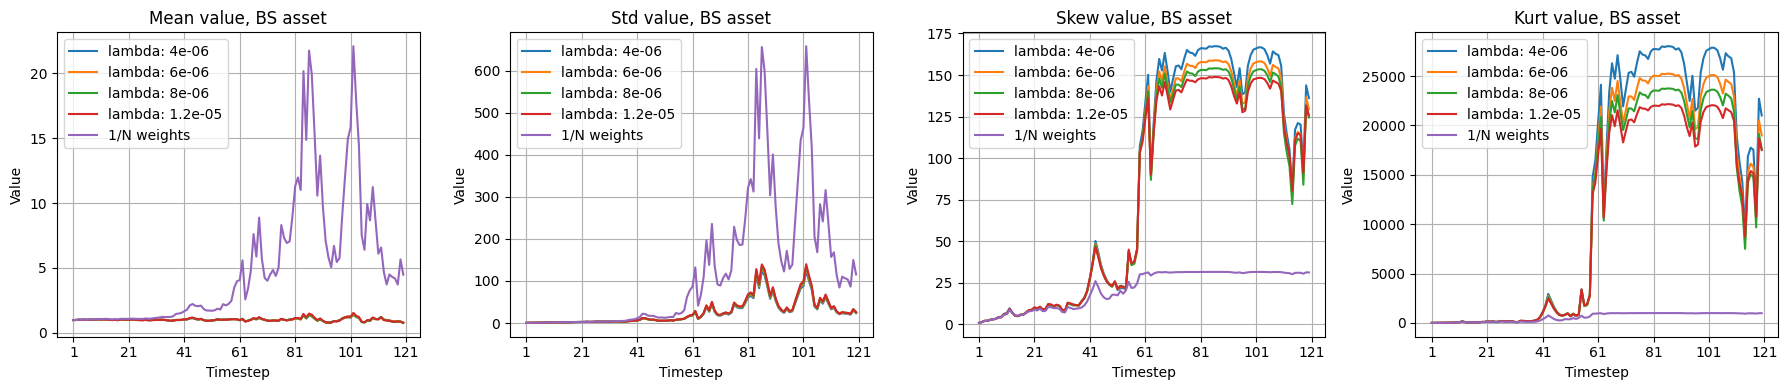

In [101]:
x = np.arange(1, 121, 1)
l_arr = df_stat['L'].values[1:5]

base = {0: np.mean(S[1:], axis = 1), 1: np.std(S[1:], axis = 1), 2: skew(S[1:], axis = 1), 3: kurtosis(S[1:], axis = 1)}
names = ['Mean', 'Std', 'Skew', 'Kurt']
m1, m2 = 1, 4
fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(18, 4))
axes = ax.flatten()
for i in range(m2):
    for j in l_arr:
        sns.lineplot(x = x, y = df_valid_m[df_valid_m['L'] == j][names[i]].values, ax = axes[i], label = 'lambda: ' + str(j))
    sns.lineplot(x = x, y = base[i], ax = axes[i], label = '1/N weights')
    axes[i].set_title(names[i] + ' value, ' + 'BS' + ' asset')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].set_xticks(np.arange(1, 122, 20))
    axes[i].grid()
    if names[i] == 'kurt':
        axes[i].set_yscale('log')

plt.tight_layout()
plt.savefig('moments_all.png')
plt.show()

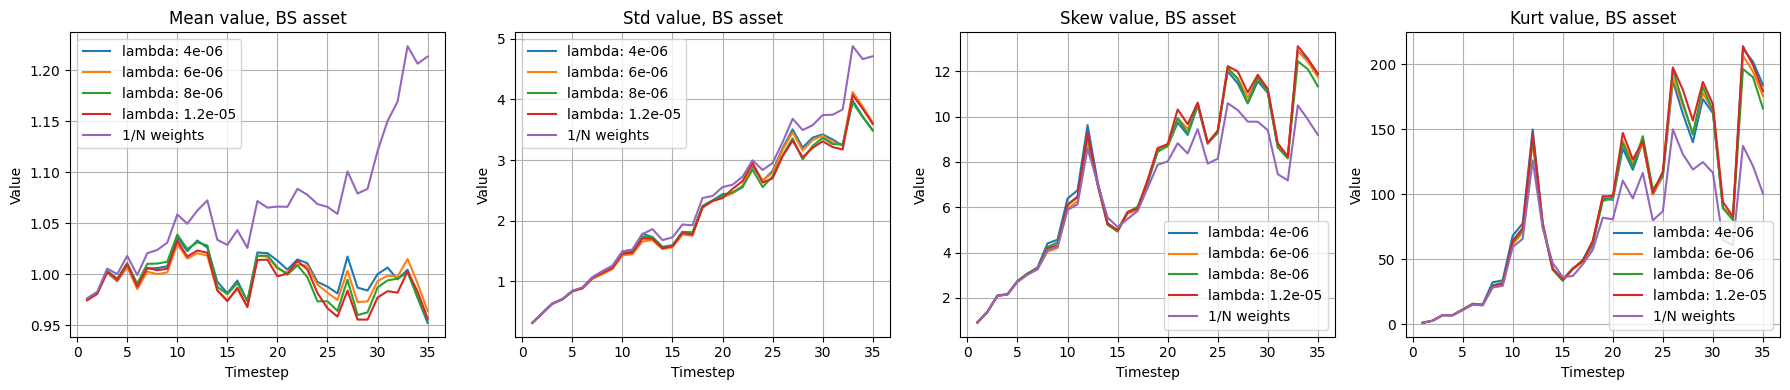

In [103]:
t = 35
x = np.arange(1, t+1,  1)
l_arr = df_stat['L'].values[1:5]

base = {0: np.mean(S[1:], axis = 1)[:t], 1: np.std(S[1:], axis = 1)[:t], 2: skew(S[1:], axis = 1)[:t], 3: kurtosis(S[1:], axis = 1)[:t]}
names = ['Mean', 'Std', 'Skew', 'Kurt']
m1, m2 = 1, 4
fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(18, 4))
axes = ax.flatten()
for i in range(m2):
    for j in l_arr:
        sns.lineplot(x = x, y = df_valid_m[df_valid_m['L'] == j][names[i]].values[:t], ax = axes[i], label = 'lambda: ' + str(j))
    sns.lineplot(x = x, y = base[i], ax = axes[i], label = '1/N weights')
    axes[i].set_title(names[i] + ' value, ' + 'BS' + ' asset')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    #axes[i].set_xticks(np.arange(1, 36, 1))
    axes[i].grid()
    if names[i] == 'kurt':
        axes[i].set_yscale('log')

plt.tight_layout()
plt.savefig('moments_part.png')
plt.show()

In [105]:
len(x)

36

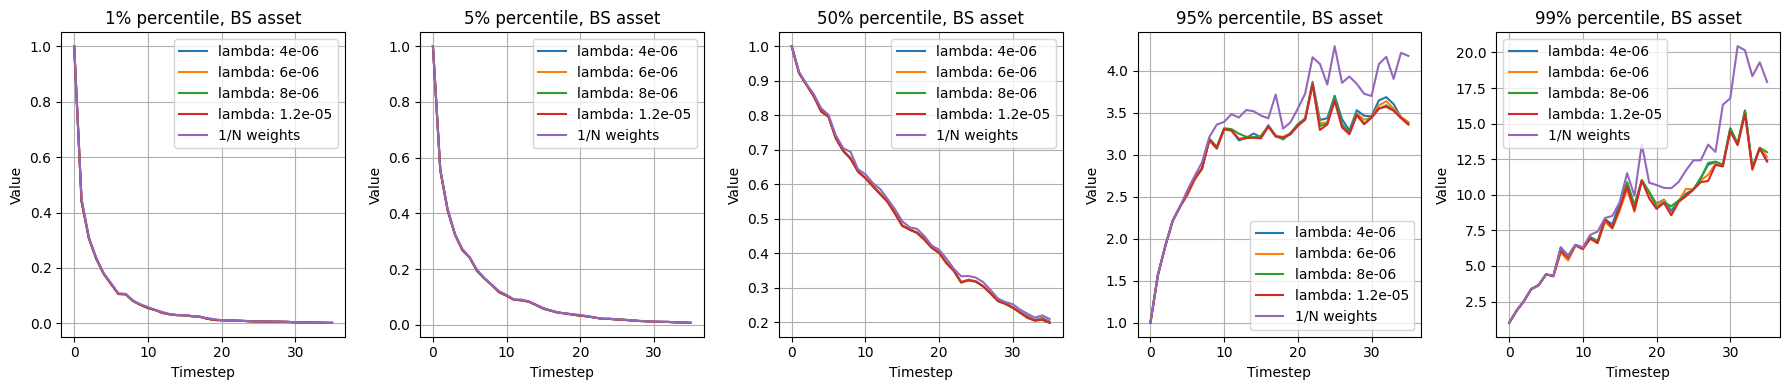

In [112]:
t = 36
x = np.arange(0, t, 1)
l_arr = df_stat['L'].values[1:5]
base = {0: np.percentile(a = S, q = 1, axis = 1, method = 'linear')[:t], 1: np.percentile(a = S[:], q = 5, axis = 1, method = 'linear')[:t], 
       2: np.percentile(a = S[:], q = 50, axis = 1, method = 'linear')[:t], 3: np.percentile(a = S[:], q = 95, axis = 1, method = 'linear')[:t], 
       4: np.percentile(a = S[:], q = 99, axis = 1, method = 'linear')[:t]}

m1, m2 = 1, len(p)
fig, ax = plt.subplots(nrows = m1, ncols = m2, figsize=(18, 4))
axes = ax.flatten()
for i in range(m2):
    for j in l_arr:
        sns.lineplot(x = x, y = df_valid_p[df_valid_p['L'] == j][str(p[i])].values[:t], ax = axes[i], label = 'lambda: ' + str(j))
    sns.lineplot(x = x, y = base[i], ax = axes[i], label = '1/N weights')
    axes[i].set_title(str(p[i]) + '% percentile, ' + 'BS' + ' asset')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    #axes[i].set_xticks(np.arange(0, 121, 20))
    axes[i].grid()

plt.tight_layout()
#plt.savefig('percentiles_part.png')
plt.show()

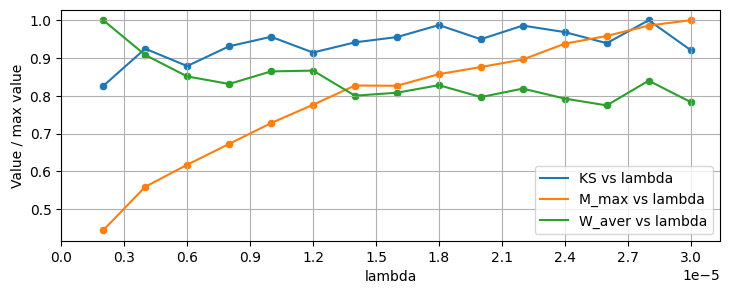

In [17]:
x = df_stat['L'].values

m1 = np.max(df_stat['KS'].values)
m2 = np.max(df_stat['M_max'].values)
m3 = np.max(df_stat['W_aver'].values)

fig, ax = plt.subplots()
sns.lineplot(x = x, y = df_stat['KS'].values / m1, label = 'KS vs lambda')
sns.scatterplot(x = x, y = df_stat['KS'].values / m1)

sns.lineplot(x = x, y = df_stat['M_max'].values / m2, label = 'M_max vs lambda')
sns.scatterplot(x = x, y = df_stat['M_max'].values / m2)

sns.lineplot(x = x, y = df_stat['W_aver'].values /m3, label = 'W_aver vs lambda')
sns.scatterplot(x = x, y = df_stat['W_aver'].values /m3)

plt.xlabel('lambda')
plt.ylabel('Value / max value')
#ax.set_yscale('log')
plt.xticks(np.arange(0, max(x) + 0.001/n, 0.000003))
fig.set_figheight(3)
fig.set_figwidth(8.5)
plt.legend()
plt.grid()
plt.savefig('KS+Mvslambda.png')
plt.show()

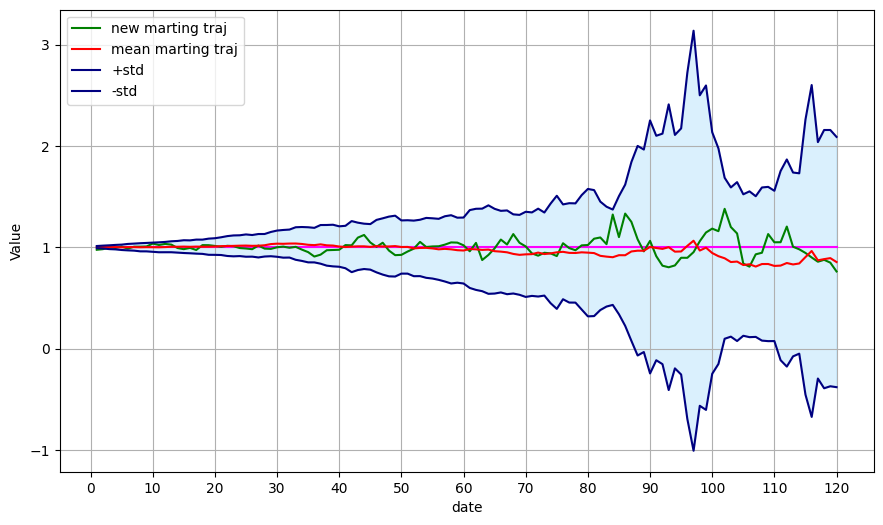

In [37]:
new_mart = S @ result.x.reshape(1000, -1).flatten()

x = df_martingale['Timestep'].values[1:]

mean_seed = df_martingale_all.groupby('Timestep').mean()['BS'].values
std = df_martingale_all.groupby('Timestep').std()['BS'].values

fig, ax = plt.subplots()  

#sns.lineplot(x = x, y = df_martingale['BS'].values[1:], color = 'navy')
sns.lineplot(x = x, y = 1.0, color = 'fuchsia')
sns.lineplot(x = x, y = new_mart[1:], color = 'green', label = 'new marting traj')
#sns.lineplot(x = x, y = (y @ W_mean).flatten()[1:], color = 'gold')
#sns.lineplot(x = x, y = list(map(lambda x: x * 1, l1_error)), color = 'green')

sns.lineplot(x = x, y = mean_seed[1:], color = 'red', label = 'mean marting traj')    
sns.lineplot(x = x, y = mean_seed[1:] + std[1:] , label = '+std', color = 'navy')
a = sns.lineplot(x = x, y = mean_seed[1:] - std[1:] , label = '-std', color = 'navy')

line = a.get_lines()
plt.fill_between(line[-3].get_xdata(), line[-2].get_ydata(), line[-1].get_ydata(), color='lightskyblue', alpha=.3)


plt.xlabel('date')
plt.ylabel('Value')
fig.set_figheight(6)
fig.set_figwidth(10.5)

#ax.set_yscale('log')

plt.xticks(np.arange(0, x.max()+1, 10))
plt.grid()

plt.show() 